In [2]:
import numpy as np
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import os
import datetime
from collections import Counter
import pickle
import time
import timeit
import math
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial import distance
import re
from itertools import groupby
from operator import itemgetter
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
%timeit
# %load_ext cython

# Get data

In [3]:
# path = os.getcwd()
path = '/Users/yingjiang/Dropbox/Learnings/Stats_data/Projects/FBCheckins'
os.listdir(path)
location = pd.read_csv(path + '/train.csv')


In [147]:
locSmallRand = location.sample(n=100000, frac=None, replace=False, weights=None, random_state=1, axis=None)
print len(locSmallRand.place_id.unique())

In [14]:
locSort = location.sort(['place_id'])
locSmaller = locSort.iloc[:8082, :] # 27 locations
# locSmaller.place_id.unique()
# print len(locSmaller.place_id.unique())


# # Attempts to count place_ids
# base = 0
# for i in Counter(locSmaller.place_id).values():
#     base += i
#     print base
    
# max(Counter(locSmaller.place_id).values())
# Counter(locSmaller.place_id)

# # Attempts to get color scale
# print preprocessing.scale((locSmaller.place_id.unique()))
# print min_max_scaler.fit_transform(locSmaller.place_id.unique())
# print (locSmaller.place_id.unique() - locSmaller.place_id.unique().min()) / locSmaller.place_id.unique().ptp()
# print min_max_scaler.fit_transform(np.array(range(7)))
# print min_max_scaler.fit_transform(np.array(range(0, 36, 5)))

/Users/yingjiang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


# Explore 'x' and 'y'

### Visualize frequencies of raw features (x and y) with histograms

(array([    77.,   7938.,  50224.,  19553.,  10136.,   6022.,   3655.,
          2411.,   1619.,   1197.,    923.,    670.,    551.,    404.,
           355.,    276.,    240.,    197.,    188.]),
 array([ 0.   ,  0.005,  0.01 ,  0.015,  0.02 ,  0.025,  0.03 ,  0.035,
         0.04 ,  0.045,  0.05 ,  0.055,  0.06 ,  0.065,  0.07 ,  0.075,
         0.08 ,  0.085,  0.09 ,  0.095]),
 <a list of 19 Patch objects>)

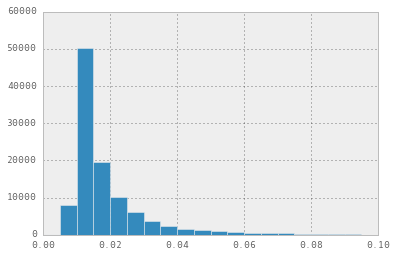

In [410]:
# The whole dataset: y is very narrowly distributed.
y_std = location.groupby(['place_id'])['y'].std()
plt.hist(y_std, bins=np.arange(0,0.1,0.005))

(array([ 2.,  1.,  2.,  4.,  2.,  4.,  1.,  2.,  1.,  1.,  1.,  0.,  4.,
         0.,  0.,  2.,  0.,  0.,  0.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9]),
 <a list of 19 Patch objects>)

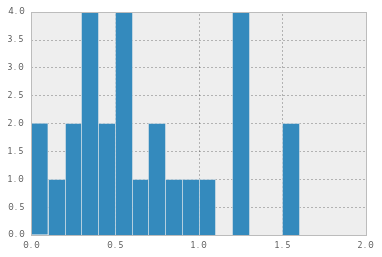

In [420]:
# The smaller dataset: x is much more widely scattered
x_std = locSmaller.groupby(['place_id'])['x'].std()

plt.hist(x_std, bins=np.arange(0,2,0.1))

In [ ]:
# # Conclusions:
# 1. y coordinates are much less scattered than x coordinates.
# 2. x coordinates are sometimes multimodal.
# 3. Widely scattered x is sometimes due to insufficient data (number of visits)

### Overview y vs x coordinates plots for the first 27 locations.

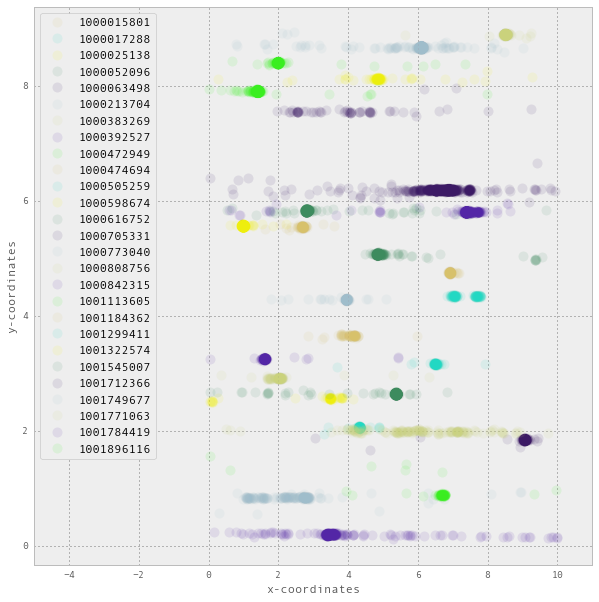

In [411]:
# 0.
# colors = locSmaller.place_id
# 1.
# colors = preprocessing.scale(locSmaller.place_id)
# 2.
# colors = plt.cm.coolwarm(locSmaller.place_id)
# colors = plt.cm.coolwarm(preprocessing.scale(locSmaller.place_id))
# 3.
# min_max_scaler = preprocessing.MinMaxScaler()
# colors = plt.cm.coolwarm(min_max_scaler.fit_transform(locSmaller.place_id))
# 4.
# colors = plt.cm.coolwarm(min_max_scaler.fit_transform(np.array(range(7))))
# colors = plt.cm.coolwarm(np.array(range(0, 36, 5)))
# 5.
plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(len(locSmaller.place_id.unique()[:9]), color_type='random')
# colors = pd.tools.plotting._get_standard_colors(len(locSmaller.place_id), color_type='random')
# 6.
# colors = plt.cm.coolwarm(locSmaller.place_id - locSmaller.place_id.min())
# 7.
# colors = [math.log(float(i)) for i in locSmaller.place_id]

# 1.
# plt.scatter(locSmaller.x, locSmaller.y, s=1, c=colors, alpha=0.5)
# 2.
# plt.scatter(locSmaller.x, locSmaller.y, s=80, c=colors, cmap=plt.cm.coolwarm)
# 3.
locG1 = locSmaller.groupby('place_id')
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_color_cycle(colors)
ax.margins(0.05)
ax.set_xlim([-5, 11])
plt.xlabel('x-coordinates')
plt.ylabel('y-coordinates')
# ax.set_ylim([-8, 11])

for name, group in locG1:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=10, label=name, alpha = 0.1, markeredgecolor='none')
#    ax.scatter(group.x, group.y, s=50, c = np.array(colors), alpha = 0.1, edgecolor=np.array(colors))

ax.legend(numpoints=1, loc='upper left')


plt.show()



### Visualize frequencies of x and y coordinates for each of the 27 places with histograms

In [ ]:
# Histogram of x and y coordinates frequencies. Places 1 - 9

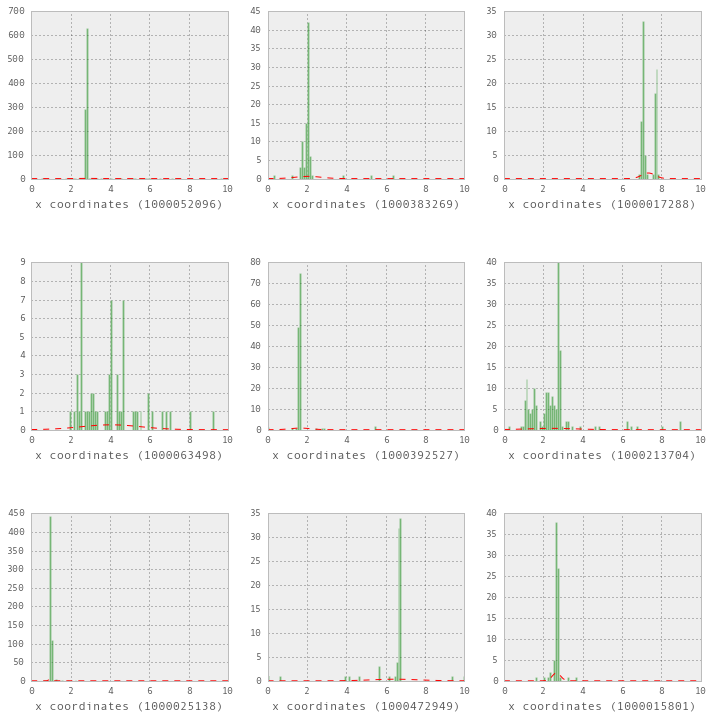

In [341]:
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

for i, j in zip(locG.groups.keys()[:9], range(9)):
    locG_individual = locG.get_group(i)
    
    plt.subplot(int('33'+ str(j+1)))
    n, bins, patches = plt.hist(locG_individual.x, bins=np.arange(0, 10+0.1, 0.1), normed = None, facecolor = 'green', alpha = 0.5)
    y = mlab.normpdf(bins, locG_individual.x.mean(), locG_individual.x.std())
    l = plt.plot(bins, y, 'r--', linewidth = 1)
    # plt.xlabel('x coordinates (Place ID: ' + str(locG_individual.place_id.iloc[0]) + ')')
    plt.xlabel('x coordinates (' + str(locG_individual.place_id.iloc[0]) + ')')
    # plt.ylabel('Frequency checked in')
    # plt.title('Histogram of x coordinates')
    # plt.axis([locG_individual.x.mean() - locG_individual.x.std(),
    #           locG_individual.x.mean() + locG_individual.x.std(), 0, 8])
    # plt.axis([0, 50, 0, n.max()])
    plt.grid(True)

plt.show()

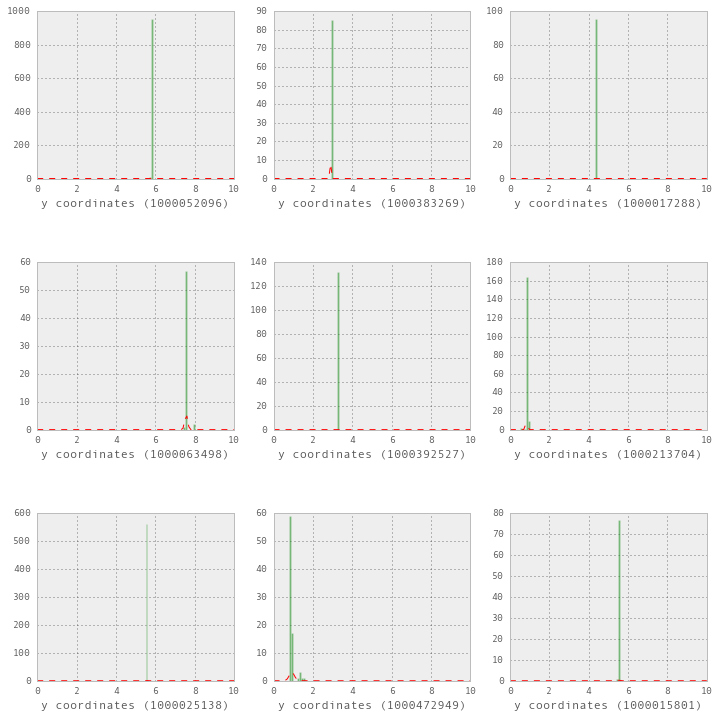

In [352]:
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

for i, j in zip(locG.groups.keys()[:9], range(9)):
    locG_individual = locG.get_group(i)
    
    plt.subplot(int('33'+ str(j+1)))
    n, bins, patches = plt.hist(locG_individual.y, bins=np.arange(0, 10+0.1, 0.1), normed = None, facecolor = 'green', alpha = 0.5)
    y = mlab.normpdf(bins, locG_individual.y.mean(), locG_individual.y.std())
    l = plt.plot(bins, y, 'r--', linewidth = 1)
    # plt.xlabel('x coordinates (Place ID: ' + str(locG_individual.place_id.iloc[0]) + ')')
    plt.xlabel('y coordinates (' + str(locG_individual.place_id.iloc[0]) + ')')
    # plt.ylabel('Frequency checked in')
    # plt.title('Histogram of x coordinates')
    # plt.axis([locG_individual.x.mean() - locG_individual.x.std(),
    #           locG_individual.x.mean() + locG_individual.x.std(), 0, 8])
    plt.grid(True)

plt.show()

In [ ]:
# Histogram of x and y coordinates frequencies. Places 10 - 18

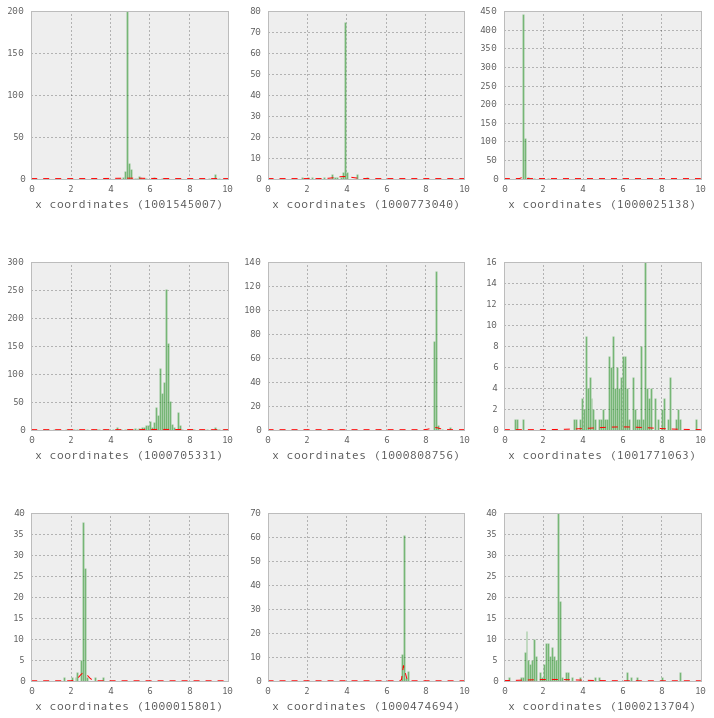

In [356]:
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

for i, j in zip(locG.groups.keys()[9:18], range(9)):
    locG_individual = locG.get_group(i)
    
    plt.subplot(int('33'+ str(j+1)))
    n, bins, patches = plt.hist(locG_individual.x, bins=np.arange(0, 10+0.1, 0.1), normed = None, facecolor = 'green', alpha = 0.5)
    y = mlab.normpdf(bins, locG_individual.x.mean(), locG_individual.x.std())
    l = plt.plot(bins, y, 'r--', linewidth = 1)
    plt.xlabel('x coordinates (' + str(locG_individual.place_id.iloc[0]) + ')')
    plt.grid(True)

plt.show()

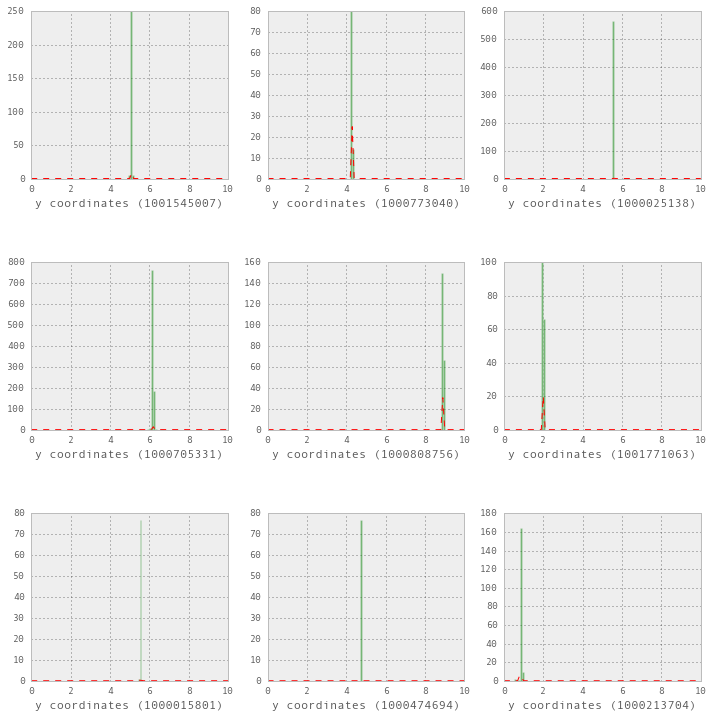

In [357]:
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

for i, j in zip(locG.groups.keys()[9:18], range(9)):
    locG_individual = locG.get_group(i)
    
    plt.subplot(int('33'+ str(j+1)))
    n, bins, patches = plt.hist(locG_individual.y, bins=np.arange(0, 10+0.1, 0.1), normed = None, facecolor = 'green', alpha = 0.5)
    y = mlab.normpdf(bins, locG_individual.y.mean(), locG_individual.y.std())
    l = plt.plot(bins, y, 'r--', linewidth = 1)
    plt.xlabel('y coordinates (' + str(locG_individual.place_id.iloc[0]) + ')')
    plt.grid(True)

plt.show()

In [ ]:
# Histogram of x and y coordinates frequencies. Places 19 - 27

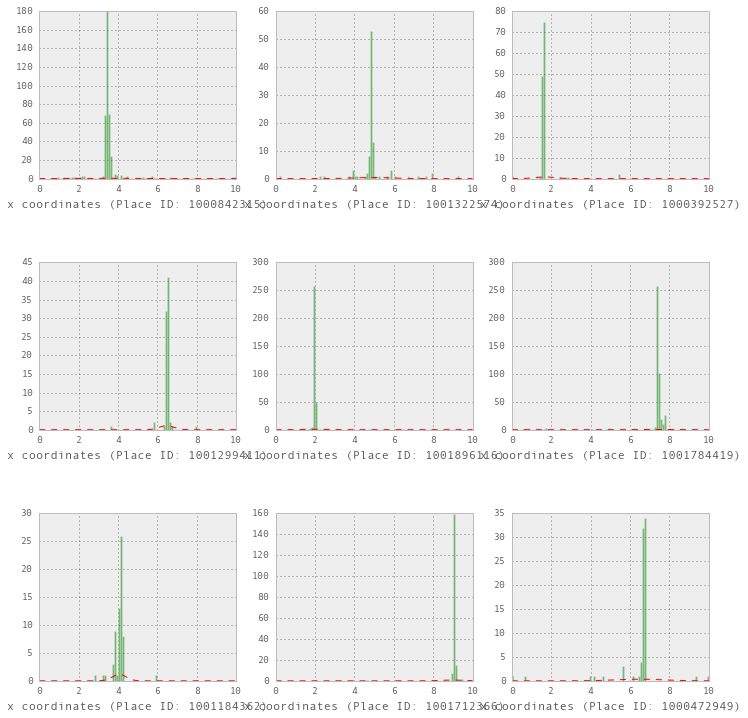

In [358]:
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

for i, j in zip(locG.groups.keys()[18:], range(9)):
    locG_individual = locG.get_group(i)
    
    plt.subplot(int('33'+ str(j+1)))
    n, bins, patches = plt.hist(locG_individual.x, bins=np.arange(0, 10+0.1, 0.1), normed = None, facecolor = 'green', alpha = 0.5)
    y = mlab.normpdf(bins, locG_individual.x.mean(), locG_individual.x.std())
    l = plt.plot(bins, y, 'r--', linewidth = 1)
    plt.xlabel('x coordinates (Place ID: ' + str(locG_individual.place_id.iloc[0]) + ')')
    # plt.ylabel('Frequency checked in')
    # plt.title('Histogram of x coordinates')
    # plt.axis([locG_individual.x.mean() - locG_individual.x.std(),
    #           locG_individual.x.mean() + locG_individual.x.std(), 0, 8])
    plt.grid(True)

plt.show()

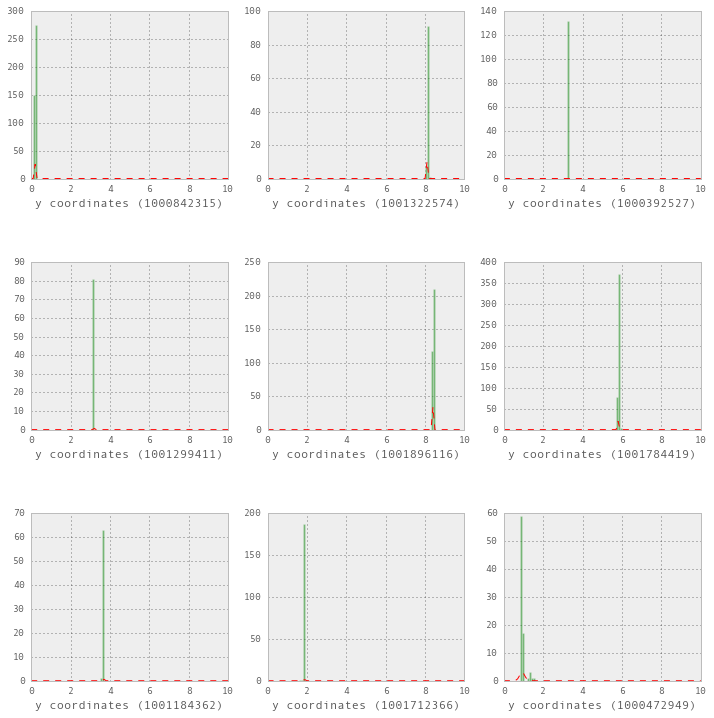

In [359]:
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

for i, j in zip(locG.groups.keys()[18:], range(9)):
    locG_individual = locG.get_group(i)
    
    plt.subplot(int('33'+ str(j+1)))
    n, bins, patches = plt.hist(locG_individual.y, bins=np.arange(0, 10+0.1, 0.1), normed = None, facecolor = 'green', alpha = 0.5)
    y = mlab.normpdf(bins, locG_individual.y.mean(), locG_individual.y.std())
    l = plt.plot(bins, y, 'r--', linewidth = 1)
    plt.xlabel('y coordinates (' + str(locG_individual.place_id.iloc[0]) + ')')
    plt.grid(True)

plt.show()

# Explore 'accuracy'

### Visualize frequencies of raw features (accuracy) with histograms

(array([ 0.,  2.,  0.,  2.,  4.,  2.,  4.,  3.,  3.,  3.,  2.]),
 array([ 40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150]),
 <a list of 11 Patch objects>)

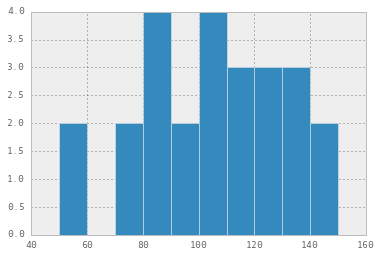

In [427]:
# location.accuracy.describe()
plt.hist(location.accuracy, bins=range(0, 300, 10))
plt.hist(locSmaller.accuracy, bins=range(0, 300, 10))
# Conclusions:
# Accuracy is identically distributed for the entire dataset and the subset - which is good - we can conclude something from the 27 places.
# 3 "peaks": most common accuracy values.
# Most have accuracies of 75 and smaller (75 percentile).
# Middle peak generates the most accurate x coordinates (see 3 plots below)

# Measure of scatter for "accuracy" for the 27 places.
acc_std = locSmaller.groupby(['place_id'])['accuracy'].std()
plt.hist(acc_std, bins=np.arange(40,160,10)) # Large scatter in accuracy than x or y.

### y vs x coordinates plots for the 3 accuracy ranges

In [ ]:
# y vs x coordinates plots for the first 27 locations, for accuracy < 40 

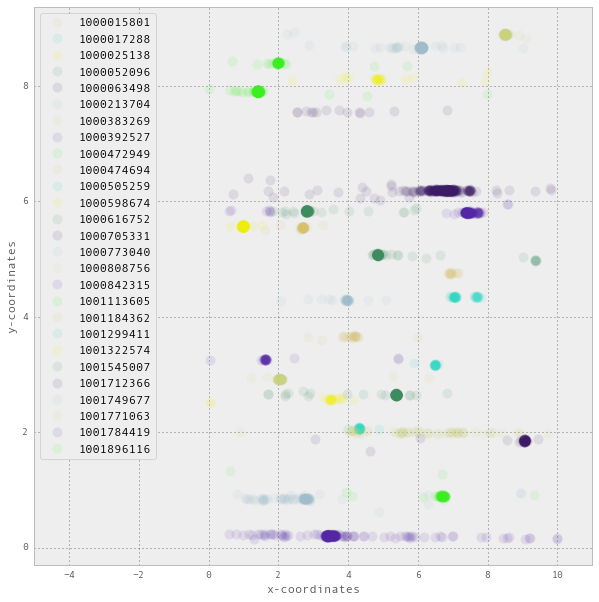

In [417]:

plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(len(locSmaller.place_id.unique()[:9]), color_type='random')

locG_acc = locSmaller[locSmaller.accuracy < 40].groupby('place_id')
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_color_cycle(colors)
ax.margins(0.05)
ax.set_xlim([-5, 11])
plt.xlabel('x-coordinates')
plt.ylabel('y-coordinates')
# ax.set_ylim([-8, 11])

for name, group in locG_acc:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=10, label=name, alpha = 0.1, markeredgecolor='none')
#    ax.scatter(group.x, group.y, s=50, c = np.array(colors), alpha = 0.1, edgecolor=np.array(colors))

ax.legend(numpoints=1, loc='upper left')


plt.show()

In [ ]:
# y vs x coordinates plots for the first 27 locations, for accuracy between 50 and 150

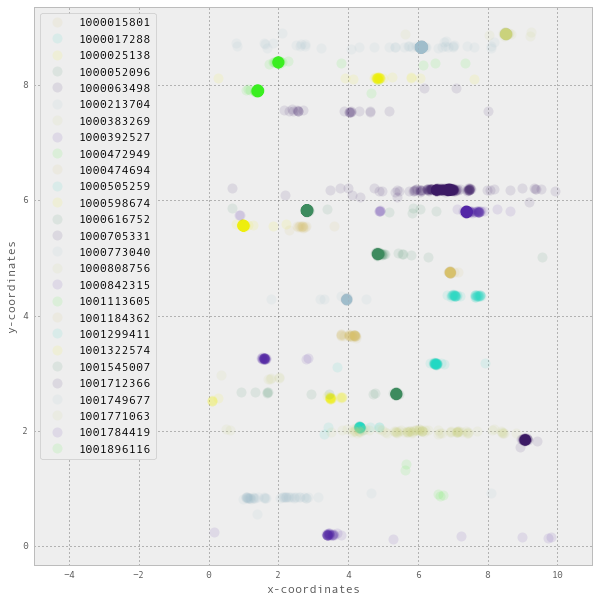

In [416]:

plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(len(locSmaller.place_id.unique()[:9]), color_type='random')

locG_acc = locSmaller[(locSmaller.accuracy < 150) & (locSmaller.accuracy >50)].groupby('place_id')
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_color_cycle(colors)
ax.margins(0.05)
ax.set_xlim([-5, 11])
plt.xlabel('x-coordinates')
plt.ylabel('y-coordinates')
# ax.set_ylim([-8, 11])

for name, group in locG_acc:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=10, label=name, alpha = 0.1, markeredgecolor='none')
#    ax.scatter(group.x, group.y, s=50, c = np.array(colors), alpha = 0.1, edgecolor=np.array(colors))

ax.legend(numpoints=1, loc='upper left')


plt.show()



In [ ]:
# y vs x coordinates plots for the first 27 locations, for accuracy > 150

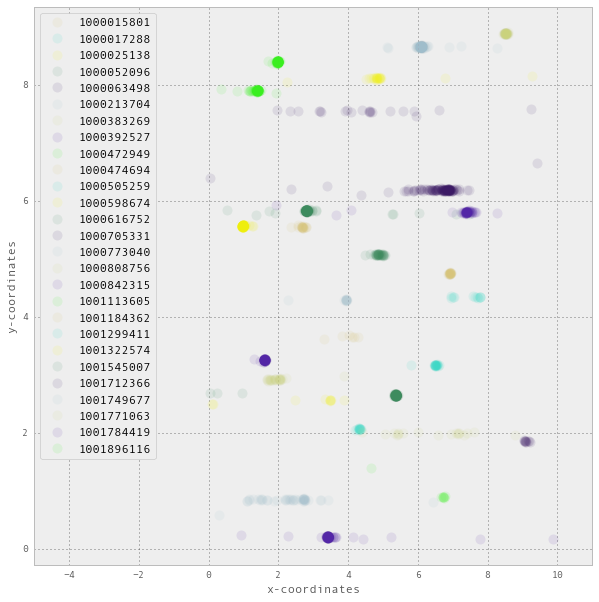

In [414]:

plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(len(locSmaller.place_id.unique()[:9]), color_type='random')

locG_acc = locSmaller[locSmaller.accuracy > 150].groupby('place_id')
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_color_cycle(colors)
ax.margins(0.05)
ax.set_xlim([-5, 11])
plt.xlabel('x-coordinates')
plt.ylabel('y-coordinates')
# ax.set_ylim([-8, 11])

for name, group in locG_acc:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=10, label=name, alpha = 0.1, markeredgecolor='none')
#    ax.scatter(group.x, group.y, s=50, c = np.array(colors), alpha = 0.1, edgecolor=np.array(colors))

ax.legend(numpoints=1, loc='upper left')


plt.show()



In [ ]:
# Accuracy vs x coordinates plots

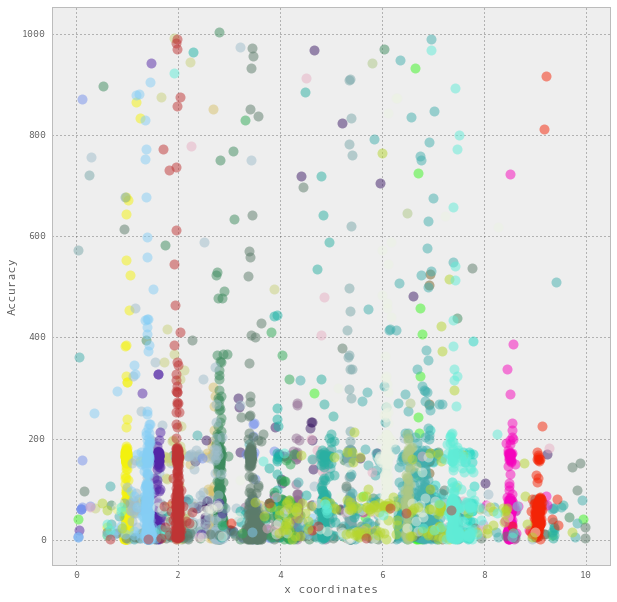

In [489]:
plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(len(locSmaller.place_id.unique()), color_type='random')

locG1 = locSmaller.groupby('place_id')
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_color_cycle(colors)
ax.margins(0.05)
plt.xlabel('x coordinates')
plt.ylabel('Accuracy')
# ax.set_xlim([4, 6])
# ax.set_ylim([0, 400])

for name, group in locG1:
    ax.plot(group.x, group.accuracy, marker='o', linestyle='', ms=10, label=name, alpha = 0.5, markeredgecolor='none')
#    ax.scatter(group.x, group.y, s=50, c = np.array(colors), alpha = 0.1, edgecolor=np.array(colors))

# ax.legend(numpoints=1, loc='upper left')

plt.show()
# Conclusions:
# It does seem that, for lower accuracies, > 100, x seems to be more scattered ("fat roots")
# When accuracies is in the middle range, between 100 and 400, x's scatter narrows ("thinning stems")
# For very high accuracies, > 400, x's scatter enlarges again, for some of the locations. Also there're fewer data points ("swaying top")
# This visualization improves the ranges as deteremined from the histograms (>40, between 40 and 150, > 150 - which are just frequencies)
# HOWEVER, the smaller variation in x for middle-range, as compared to lower-range, could just be because there are fewer points in the middle range.
# Less data, less variation.

# Visualize outliers

### Calculate scatter in x

In [378]:
outliers = pd.DataFrame()
outliers['place_id'] = locSmaller.place_id.unique()
outliers['x_pk_descr'] = np.array(['NM', 'M', 'NM', 'W', 'NM', 'W', 'N', 'N', 'M', 'N', 'N', 'N', 'M', 'NM', 'W', 'NM', 'N', 'W', 'M', 'N', 'NM', 'NM', 'N', 'NM', 'M', 'N', 'NM'])
outliers['x_std'] = locG['x'].std().values
outliers['x_IQRRatio'] = ((locG['x'].quantile(0.75) - locG['x'].quantile(0.25)) / (locG['x'].max() - locG['x'].min())).values
outliers

place_id x_pk_descr     x_std  x_IQRRatio
0   1000015801         NM  0.208356    0.023418
1   1000017288          M  0.338709    0.691419
2   1000025138         NM  0.076025    0.014868
3   1000052096          W  0.473961    0.002091
4   1000063498         NM  1.523148    0.268068
5   1000213704          W  1.255604    0.136136
6   1000383269          N  0.666072    0.020704
7   1000392527          N  0.516834    0.004865
8   1000472949          M  1.203933    0.008277
9   1000474694          N  0.054326    0.074578
10  1000505259          N  0.176851    0.013460
11  1000598674          N  1.234809    0.011245
12  1000616752          M  0.728754    0.003509
13  1000705331         NM  0.826700    0.038102
14  1000773040          W  0.408213    0.008062
15  1000808756         NM  0.217727    0.009983
16  1000842315          N  1.273262    0.016644
17  1001113605          W  0.340740    0.002679
18  1001184362          M  0.348115    0.059523
19  1001299411          N  0.368142    0.008170
20  1001322574         NM  1.009434    0.010921
21  1001545007         NM  0.796760    0.008720
22  1001712366          N  0.586648    0.004638
23  1001749677         NM  0.583456    0.003140
24  1001771063          M  1.504001    0.196855
25  1001784419          N  0.940589    0.007317
26  1001896116         NM  0.533189    0.003131

### Compare IQRRatio's measure of scatter with visual inspection of x, y coordinate histograms

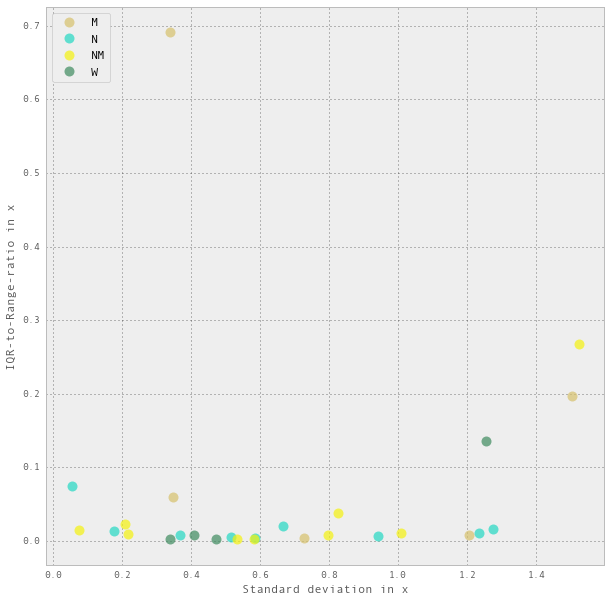

In [381]:
plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(len(outliers.x_pk_descr.unique()), color_type='random')

outliersG = outliers.groupby('x_pk_descr')
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_color_cycle(colors)
ax.margins(0.05)
plt.xlabel('Standard deviation in x')
plt.ylabel('IQR-to-Range-ratio in x')

for name, group in outliersG:
    ax.plot(group.x_std, group.x_IQRRatio, marker='o', linestyle='', ms=10, label=name, alpha = 0.7, markeredgecolor='none')
#    ax.scatter(group.x, group.y, s=50, c = np.array(colors), alpha = 0.1, edgecolor=np.array(colors))

ax.legend(numpoints=1, loc='upper left')

plt.show()

# Conclusions
# Points classified as "Narrow" or "Narrow multimodal" mostly have very small IQR-to-range values. Ie most of the x's lie within the IQR.
# Points classified as "Medium" or "Wide" do have a higher ratio of large IQR-to-range values, but low ratios still form the majority.

### Compare IQRRatio's measure of scatter with accuracy's
#### Previously shown: middle-acc x removes the most outliers.


In [435]:
outliers['x_IQRRatioLabel'] = pd.Series(0)
outliers['x_IQRRatioLabel'][outliers.x_IQRRatio < 0.05] = 0
outliers['x_IQRRatioLabel'][(outliers.x_IQRRatio > 0.05) & (outliers.x_IQRRatio < 0.1)] = 1
outliers['x_IQRRatioLabel'][(outliers.x_IQRRatio > 0.1) & (outliers.x_IQRRatio < 0.3)] = 2
outliers['x_IQRRatioLabel'][outliers.x_IQRRatio > 0.3] = 3
outliers

/Users/yingjiang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/yingjiang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/yingjiang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/yingjiang/miniconda2/lib/python2.7/site

place_id x_pk_descr     x_std  x_IQRRatio  x_IQRRatioLabel
0   1000015801         NM  0.208356    0.023418              0.0
1   1000017288          M  0.338709    0.691419              3.0
2   1000025138         NM  0.076025    0.014868              0.0
3   1000052096          W  0.473961    0.002091              0.0
4   1000063498         NM  1.523148    0.268068              2.0
5   1000213704          W  1.255604    0.136136              2.0
6   1000383269          N  0.666072    0.020704              0.0
7   1000392527          N  0.516834    0.004865              0.0
8   1000472949          M  1.203933    0.008277              0.0
9   1000474694          N  0.054326    0.074578              1.0
10  1000505259          N  0.176851    0.013460              0.0
11  1000598674          N  1.234809    0.011245              0.0
12  1000616752          M  0.728754    0.003509              0.0
13  1000705331         NM  0.826700    0.038102              0.0
14  1000773040          W  0.408213    0.008062              0.0
15  1000808756         NM  0.217727    0.009983              0.0
16  1000842315          N  1.273262    0.016644              0.0
17  1001113605          W  0.340740    0.002679              0.0
18  1001184362          M  0.348115    0.059523              1.0
19  1001299411          N  0.368142    0.008170              0.0
20  1001322574         NM  1.009434    0.010921              0.0
21  1001545007         NM  0.796760    0.008720              0.0
22  1001712366          N  0.586648    0.004638              0.0
23  1001749677         NM  0.583456    0.003140              0.0
24  1001771063          M  1.504001    0.196855              2.0
25  1001784419          N  0.940589    0.007317              0.0
26  1001896116         NM  0.533189    0.003131              0.0

In [477]:
locSmaller['x_Scatter'] = pd.Series(0)

# len(locSmaller['x_Scatter'][locSmaller.place_id == outliers.place_id[outliers.x_IQRRatioLabel == 0]])
# [locSmaller.ix[locSmaller.place_id == i, 'x_Scatter'] = 0 for i in outliers.place_id[outliers.x_IQRRatioLabel == 0]]

for i in outliers.place_id[outliers.x_IQRRatioLabel == 0]:
    locSmaller.ix[locSmaller.place_id == i, 'x_Scatter'] = 0
    
for i in outliers.place_id[outliers.x_IQRRatioLabel == 1]:
    locSmaller.ix[locSmaller.place_id == i, 'x_Scatter'] = 1
    
for i in outliers.place_id[outliers.x_IQRRatioLabel == 2]:
    locSmaller.ix[locSmaller.place_id == i, 'x_Scatter'] = 2

for i in outliers.place_id[outliers.x_IQRRatioLabel == 3]:
    locSmaller.ix[locSmaller.place_id == i, 'x_Scatter'] = 3

/Users/yingjiang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


(8082, 7)


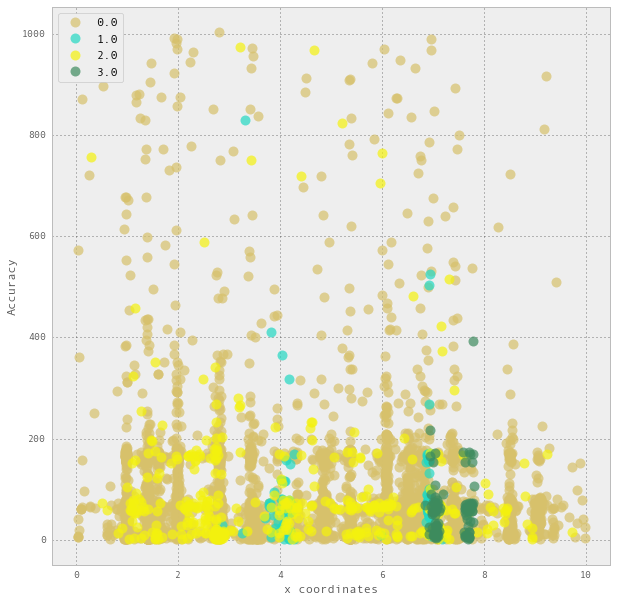

In [479]:
plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(len(outliers.x_pk_descr.unique()), color_type='random')

locG1 = locSmaller.groupby('x_Scatter')
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_color_cycle(colors)
ax.margins(0.05)
plt.xlabel('x coordinates')
plt.ylabel('Accuracy')
# ax.set_xlim([-5, 11])
# ax.set_ylim([-8, 11])

for name, group in locG1:
    ax.plot(group.x, group.accuracy, marker='o', linestyle='', ms=10, label=name, alpha = 0.7, markeredgecolor='none')
#    ax.scatter(group.x, group.y, s=50, c = np.array(colors), alpha = 0.1, edgecolor=np.array(colors))

ax.legend(numpoints=1, loc='upper left')


plt.show()
# Conclusion: x scatter as defined by IQR-Range ratios does not correspond to x scatter as defined by accuracy.

## Use accuracy only to classify scatter in x.
### Use accuracy to remove outliers in x.
### Use the following ranges in accuracy:
#### < 100
#### > 100 & < 400
#### > 400


In [509]:
locG1 = locSmaller[locSmaller.accuracy < 100].groupby('place_id')
locG2 = locSmaller[(locSmaller.accuracy > 100) & (locSmaller.accuracy < 400)].groupby('place_id')
locG3 = locSmaller[locSmaller.accuracy > 400].groupby('place_id') # Only 25 places; index 1 (1000017288), 10 (1000505259) are missing
# In fact, excluding accuracies starting from 100 will exclude certain places that have low accuracies for all its checkins.
# Some places' maximum checkin accuracy is only 1.
locationG = location.groupby('place_id')
locationG['accuracy'].max().min() # 1
locationG2 = location[(location.accuracy > 70) & (location.accuracy < 400)].groupby('place_id')
locationG2['x'].mean().shape # 107851 (including accuracies above 70 and below 400 will remove data from 539 places)

# outliers['x_std1'] = locG1['x'].std().values
# outliers['x_std2'] = locG2['x'].std().values
# outliers['x_std3'] = locG3['x'].std().values



place_id x_pk_descr     x_std  x_IQRRatio  x_IQRRatioLabel    x_std1  \
0   1000015801         NM  0.208356    0.023418              0.0  0.231909   
1   1000017288          M  0.338709    0.691419              3.0  0.331453   
2   1000025138         NM  0.076025    0.014868              0.0  0.082664   
3   1000052096          W  0.473961    0.002091              0.0  0.417103   
4   1000063498         NM  1.523148    0.268068              2.0  1.301578   
5   1000213704          W  1.255604    0.136136              2.0  1.356732   
6   1000383269          N  0.666072    0.020704              0.0  0.762243   
7   1000392527          N  0.516834    0.004865              0.0  0.814165   
8   1000472949          M  1.203933    0.008277              0.0  1.256309   
9   1000474694          N  0.054326    0.074578              1.0  0.061234   
10  1000505259          N  0.176851    0.013460              0.0  0.189381   
11  1000598674          N  1.234809    0.011245              0.0  1.212206   
12  1000616752          M  0.728754    0.003509              0.0  0.682306   
13  1000705331         NM  0.826700    0.038102              0.0  0.790016   
14  1000773040          W  0.408213    0.008062              0.0  0.401846   
15  1000808756         NM  0.217727    0.009983              0.0  0.237356   
16  1000842315          N  1.273262    0.016644              0.0  1.348877   
17  1001113605          W  0.340740    0.002679              0.0  0.357145   
18  1001184362          M  0.348115    0.059523              1.0  0.361551   
19  1001299411          N  0.368142    0.008170              0.0  0.444717   
20  1001322574         NM  1.009434    0.010921              0.0  0.999589   
21  1001545007         NM  0.796760    0.008720              0.0  0.871079   
22  1001712366          N  0.586648    0.004638              0.0  0.608949   
23  1001749677         NM  0.583456    0.003140              0.0  0.601118   
24  1001771063          M  1.504001    0.196855              2.0  1.545838   
25  1001784419          N  0.940589    0.007317              0.0  0.949603   
26  1001896116         NM  0.533189    0.003131              0.0  0.637505   

      x_std2    x_std3  
0   0.137588  0.231909  
1   0.377539  0.331453  
2   0.028012  0.082664  
3   0.534299  0.417103  
4   1.765615  1.301578  
5   0.932866  1.356732  
6   0.137524  0.762243  
7   0.038682  0.814165  
8   0.918890  1.256309  
9   0.019318  0.061234  
10  0.044844  0.189381  
11  1.099219  1.212206  
12  0.020164  0.682306  
13  1.012639  0.790016  
14  0.049707  0.401846  
15  0.034632  0.237356  
16  0.970360  1.348877  
17  0.159238  0.357145  
18  0.087889  0.361551  
19  0.042486  0.444717  
20  0.968657  0.999589  
21  0.089854  0.871079  
22  0.030700  0.608949  
23  0.351225  0.601118  
24  1.203778  1.545838  
25  0.667085  0.949603  
26  0.017490  0.637505

In [ ]:
### Conclusion:
# 1. Use y to predict first.
# 2. If certain decisions are close, then look at x. Which x is it closer to?

# Build model using y coordinates (attempt to do 10-fold cv)

In [548]:
test = location.iloc[-(location.shape[0] / 5):] # Get last 1/5 rows as testing data.
train = location.iloc[:(location.shape[0] * 4 / 5 + 1)]

cv_sets = []
for i in range(0, len(train), int(math.ceil(len(train)/10.0))):
    cv_sets.append(train[i:i+int(math.ceil(len(train)/10.0))])

In [549]:
cv = []
tr = []
for ind, obj in enumerate(cv_sets): # from 10 sets, make 1 the cv set; the rest combine into the tr set.
    cv.append(pd.DataFrame(obj))
#    print len(cv)
    tmp = cv_sets[:ind] + cv_sets[(ind+1):]
    tmp = [pd.DataFrame(i) for i in tmp]
    tmp = pd.concat(tmp)
    tr.append(tmp)
#    print len(tr)

In [564]:
# Do tr[0] and cv[0] first.
trG = tr[0].groupby('place_id')
y_mean = trG['y'].mean()
y_std = trG['y'].std()
# y_low = y_mean - y_std
# y_high = y_mean + y_std

nsmall = 2
place_id_min = []
place_id_possible = []

In [ ]:
# This algorithm is not realistic for large cv datasets...

for i in cv[0].y: # Loop through each cv point, see which tr point it's closest to.
    if (cv[0].y == i).argmax() % 100 == 0:
        print (cv[0].y == i).argmax()
    d = abs(i - y_mean)
    d_min = d.min()
    place_id_min.append(d.idxmin()) # place_id at minimal distance from cv point
    
    nsmall = 2
    d_diff = abs(d_min - d.nsmallest(nsmall).iloc[-1])
    # Get the std of y that's the current predicted point. See which are the other y's that fall within the std
    while d_diff < y_std.loc[d.idxmin()]:
        nsmall += 1
        d_diff = abs(d_min - d.nsmallest(nsmall).iloc[-1])
    place_id_possible.append(d.nsmallest(nsmall).index)

# Algorithm halted. Did not complete all data points in cv[0]
# Abandon 10-fold. Next:
# Remove x-outliers by excluding datapoints with accuracies below 70 and above 400.
# (Shrink the training set: some place_ids will be lost)
# After removal of the inaccurate locations, just take 10K data points out as cv.
# (No more 10 fold)
# Do predictions out of the new cv (10K points).

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000


# Build model using numpy arrays (using accuracy to remove x outliers)

In [4]:
# 1. Use smaller cv set. (Meanwhile removed x outliers using 'accuracy')
# 2. Use numpy arrays on smaller cv set.
# 3. Use numpy arrays on large cv set (1/5 training size)

## Subset data

In [5]:
locAcc = location[(location.accuracy > 70) & (location.accuracy < 400)]
print locAcc.shape # 107851 unique places, reduced from 108390

(8393406, 6)


## Using the small cv set (10000), train using only y coordinates

In [315]:
# Make a small cv set first
# Use locAcc (with reduced x outliers)
# Train using only y coordinates

test = locAcc.iloc[-(locAcc.shape[0] / 5):] # Get last 1/5 rows as testing data.
train = locAcc.iloc[:(locAcc.shape[0] * 4 / 5 + 1)]
cv = train.iloc[-10000:]
tr = train.iloc[:(train.shape[0]-10000)]

# # Alternatively use a randomized sample for testing and cv.
# msk = np.random.rand(len(locAcc)) < 0.8
# train = locAcc[msk]
# test = locAcc[~msk]

# msk2 = np.random.rand(len(train)) < 0.9
# tr = train[msk2]
# cv = train[~msk2]

print len(train.place_id.unique())
print len(test.place_id.unique())
print len(tr.place_id.unique())
print len(cv.place_id.unique())

107710
105616
107707
9066


In [126]:
trG = tr.groupby('place_id')
y_mean = trG['y'].mean()
y_std = trG['y'].std()

nsmall = 2
place_id_min = []
place_id_possible = []

In [315]:
   
for idx, i in enumerate(cv.y): # Loop through each cv point, see which tr point it's closest to.
    if idx % 100 == 0:
        print idx
    
    d = abs(i - y_mean)
    d_min = d.min()
    place_id_min.append(d.idxmin()) # place_id at minimal distance from cv point
    
    nsmall = 2
    d_diff = abs(d_min - d.nsmallest(nsmall).iloc[-1])
    
    # Get the std of y that's the current predicted point. See which are the other y's that fall within the std
    while d_diff < y_std.loc[d.idxmin()]:
        nsmall += 1
        d_diff = abs(d_min - d.nsmallest(nsmall).iloc[-1])
    place_id_possible.append(d.nsmallest(nsmall).index)


107710
105616
107707
9066


In [272]:
# result1: using only y; 10K points; 34 correct predictions
result1 = pd.DataFrame({
         "place_id": cv.place_id,
         "place_id_pred": place_id_min,
         "place_id_possible": place_id_possible
         }) 
sum(result1.place_id == result1.place_id_pred) # Only 34 correct predictions. Using minimal y distance is a bad model.
tmp = [len(j) < 3 for j in place_id_possible]
sum(tmp)

ind = []
for i, j in zip(place_id_min, cv.place_id):
    if i == j:
       ind.append(place_id_min.index(i))
for i in ind:
    print len(place_id_possible[i])
# All 34 of the "correct" predictions had many near-by ys. Therefore correct prediction doesn't mean narrowed-down choices for y.

34

## Using the small cv set (10000), train using x and y coordinates

In [ ]:
trG = tr.groupby('place_id')
y_mean = trG['y'].mean()
y_std = trG['y'].std()
x_mean = trG['x'].mean()

place_id_min = np.array([])
place_id_possible = np.empty((0, nsmall))

for idx, i in enumerate(cA): # Loop through each cv point, see which tr point it's closest to.
    if idx % 100 == 0:
        print "Index: ", idx

    d = distance.cdist(i.reshape(1,2), cB, 'euclidean')
    d_min = d[0].min()
    place_id_min = np.append(place_id_min, [train_ids[d[0].argmin()]]) # place_id at minimal distance from cv point
#     print "Min distance: ", d_min
#     print "Point at min distance: ", train_ids[d[0].argmin()]
#     print place_id_min

    # Get the next nsmall (x,y) that's closest to the current point.
    place_id_possible = np.append(place_id_possible, [train_ids[d[0].argsort()[:nsmall]]], axis=0)
#     print "Next ", nsmall, " closest distances: ", d[0][d[0].argsort()[:nsmall]]
#     print "Next ", nsmall, " closest points: ", train_ids[d[0].argsort()[:nsmall]]
#     print place_id_possible

Index:  0
Index:  100
Index:  200
Index:  300
Index:  400
Index:  500
Index:  600
Index:  700
Index:  800
Index:  900
Index:  1000
Index:  1100
Index:  1200
Index:  1300
Index:  1400
Index:  1500
Index:  1600
Index:  1700
Index:  1800
Index:  1900
Index:  2000
Index:  2100
Index:  2200
Index:  2300
Index:  2400
Index:  2500
Index:  2600
Index:  2700
Index:  2800
Index:  2900
Index:  3000
Index:  3100
Index:  3200
Index:  3300
Index:  3400
Index:  3500
Index:  3600
Index:  3700
Index:  3800
Index:  3900
Index:  4000
Index:  4100
Index:  4200
Index:  4300
Index:  4400
Index:  4500
Index:  4600
Index:  4700
Index:  4800
Index:  4900
Index:  5000
Index:  5100
Index:  5200
Index:  5300
Index:  5400
Index:  5500
Index:  5600
Index:  5700
Index:  5800
Index:  5900
Index:  6000
Index:  6100
Index:  6200
Index:  6300
Index:  6400
Index:  6500
Index:  6600
Index:  6700
Index:  6800
Index:  6900
Index:  7000
Index:  7100
Index:  7200
Index:  7300
Index:  7400
Index:  7500
Index:  7600
Index:  770

In [432]:
# Do the 5 nearest neighbors contain the true value?
contains = np.empty((0, result2.shape[0]))
for ind, val in enumerate(result2.place_id):
    if ind % 100 == 0:
        print ind
    contains = np.append(contains, val in result2['place_id_possible'][ind:ind+1].values[0])
sum(contains) # 3568 of them do.
# If these can be extracted, the correct predictions become 1334 + 3568 = 4902. Nearly 50%


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [331]:
# result2: using x and y; 10K points; 1334 correct predictions; potentially 3568
result2 = pd.DataFrame({
         "place_id": cv.place_id,
         "place_id_pred": place_id_min,
         "place_id_possible": place_id_possible.tolist()
         })
sum(result2.place_id == result2.place_id_pred) 
sum(contains)
result2['contains'] = contains

1334

In [441]:
pickle.dump(result2, open('cv_pred2.p', 'wb'))

## Scaling up the calculation using large cv set (1.3 M)

In [46]:
# Get a mean x.
# For the 10K predictions that are assigned to a range of y's, check the corresponding mean x's.
# Pick the mean x that's closest to the cv data's x.
# Or go for the x-y nearest neighbor

In [333]:
# Make a larger cv set: 1/5 of training data
test = locAcc.iloc[-(locAcc.shape[0] / 5):] # Get last 1/5 rows as testing data.
train = locAcc.iloc[:(locAcc.shape[0] * 4 / 5 + 1)]
cv = train.iloc[-(train.shape[0] / 5):]locA
tr = train.iloc[:(train.shape[0] * 4 / 5 + 1)]

trG = tr.groupby('place_id')
y_mean = trG['y'].mean()
y_std = trG['y'].std()
x_mean = trG['x'].mean()

cA = np.array(cv[['x', 'y']])
cB = np.column_stack((np.array(x_mean), np.array(y_mean)))
train_ids = trG['place_id'].count().index
nsmall = 10


In [285]:
# # %%cython
# def findKNN(cA = cA, cB = cB,
#            train_ids = trG['place_id'].count().index,
#            nsmall = nsmall):
#     place_id_min = np.array([])
#     place_id_possible = np.empty((0, cA.shape[0]))
    
#     for idx, i in enumerate(cA): # Loop through each cv point, see which tr point it's closest to.
#         if idx % 100 == 0:
#             print idx

#         d = distance.cdist(i.reshape(1,2), cB, 'euclidean')
#         d_min = d.min()
#         place_id_min = np.append(place_id_min, train_ids[d.argmin()]) # place_id at minimal distance from cv point

#         # Get the next nsmall (x,y) that's closest to the current point.
#         place_id_possible.append(train_ids[i[0].argsort()[:nsmall]])

# #         while d_diff < y_std.loc[d.idxmin()]:
# #             nsmall += 1
# #             d_diff = abs(d_min - d.nsmallest(nsmall).iloc[-1])
# #         place_id_possible.append(d.nsmallest(nsmall).index)
#     return np.array(place_id_min, place_id_possible)


In [ ]:
# Using the large cv set (1,340,000), train using x and y coordinates

place_id_min = np.array([])
place_id_possible = np.empty((0, nsmall))

for idx, i in enumerate(cA): # Loop through each cv point, see which tr point it's closest to.
    if idx % 100 == 0:
        print "Index: ", idx

    d = distance.cdist(i.reshape(1,2), cB, 'euclidean')
    d_min = d[0].min()
    place_id_min = np.append(place_id_min, [train_ids[d[0].argmin()]]) # place_id at minimal distance from cv point
#     print "Min distance: ", d_min
#     print "Point at min distance: ", train_ids[d[0].argmin()]
#     print place_id_min

    # Get the next nsmall (x,y) that's closest to the current point.
    place_id_possible = np.append(place_id_possible, [train_ids[d[0].argsort()[:nsmall]]], axis=0)
#     print "Next ", nsmall, " closest distances: ", d[0][d[0].argsort()[:nsmall]]
#     print "Next ", nsmall, " closest points: ", train_ids[d[0].argsort()[:nsmall]]
#     print place_id_possible

Index:  0
Index:  100
Index:  200
Index:  300
Index:  400
Index:  500
Index:  600
Index:  700
Index:  800
Index:  900
Index:  1000
Index:  1100
Index:  1200
Index:  1300
Index:  1400
Index:  1500
Index:  1600
Index:  1700
Index:  1800
Index:  1900
Index:  2000
Index:  2100
Index:  2200
Index:  2300
Index:  2400
Index:  2500
Index:  2600
Index:  2700
Index:  2800
Index:  2900
Index:  3000
Index:  3100
Index:  3200
Index:  3300
Index:  3400
Index:  3500
Index:  3600
Index:  3700
Index:  3800
Index:  3900
Index:  4000
Index:  4100
Index:  4200
Index:  4300
Index:  4400
Index:  4500
Index:  4600
Index:  4700
Index:  4800
Index:  4900
Index:  5000
Index:  5100
Index:  5200
Index:  5300
Index:  5400
Index:  5500
Index:  5600
Index:  5700
Index:  5800
Index:  5900
Index:  6000
Index:  6100
Index:  6200
Index:  6300
Index:  6400
Index:  6500
Index:  6600
Index:  6700
Index:  6800
Index:  6900
Index:  7000
Index:  7100
Index:  7200
Index:  7300
Index:  7400
Index:  7500
Index:  7600
Index:  770

In [338]:
print cv.place_id.shape
print place_id_min.shape
print place_id_possible.shape

(1342945,)
(1342945,)
(1342945, 10)


In [344]:
# result3: using x and y; 1.3M points; 183182 correct predictions; potentially 624682
result3 = pd.DataFrame({
         "place_id": cv.place_id,
         "place_id_pred": place_id_min,
         "place_id_possible": place_id_possible.tolist()
         })
sum(result3.place_id == result3.place_id_pred) / float(cv.place_id.shape[0])

0.13640320340743664

In [442]:
# Do the 5 nearest neighbors contain the true value?
contains = np.empty((0, result3.shape[0]))
for ind, val in enumerate(result3.place_id):
    if ind % 1000 == 0:
        print ind
    contains = np.append(contains, val in result3['place_id_possible'][ind:ind+1].values[0])
sum(contains) # 624682 of them do.
# If these can be extracted, the correct predictions become 183182 + 624682 = 807864. 60%!



0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


624682.0

In [449]:
result3['contains'] = contains

In [453]:
pickle.dump(result3, open('cv_pred3.p', 'wb'))

# Build model using numpy arrays (using IQR to remove x outliers)

## Subset data

In [24]:
## Trial using the small dataset
locG = locSmaller.groupby('place_id')

## Using pd.concat
locSmallerIQR_tr1 = pd.DataFrame()
start1 = timeit.default_timer()
for name, group in locG:
#     print group.x.quantile(0.75)
#     tmp = group[(group.x < group.x.quantile(0.75)) & (group.x > group.x.quantile(0.25))]
#     group['x_IQR'] = tmp
    locSmallerIQR_tr1 = pd.concat([locSmallerIQR_tr1, group[(group.x < group.x.quantile(0.75)) & (group.x > group.x.quantile(0.25))]])
stop1 = timeit.default_timer()
print stop1 - start1 # 0.288719177246
# Note: pd.concat too slow for the entire dataset


## Using np.vstack
locSmallerIQR_tr2 = np.empty((0, 6))
start2 = timeit.default_timer()
# for i in locG.groups.keys()[:5]:
#     print locIQR_tr2.shape
#     print locG.get_group(i).shape
#     locIQR_tr2 = np.vstack((locIQR_tr2, locG.get_group(i)))

for name, group  in locG:
    locSmallerIQR_tr2 = np.vstack((locSmallerIQR_tr2, group[(group.x < group.x.quantile(0.75)) & (group.x > group.x.quantile(0.25))]))
#     print locIQR_tr2.shape
stop2 = timeit.default_timer()
print stop2 - start2 # 0.144453048706
# Conclusion: np.vstack is twice faster.

print locSmaller.shape
print locSmallerIQR_tr1.shape
print locSmallerIQR_tr2.shape # Twice faster

# Convert vstack into Dataframe
locSmallerIQR_tr2 = pd.DataFrame(locSmallerIQR_tr2, columns = ['row_id', 'x', 'y', 'accuracy', 'time', 'place_id'])
# Randomize the Dataframe (which is now grouped by place_id)

0.288719177246
0.144453048706
(8082, 6)
(4007, 6)
(4007, 6)


In [32]:
locationG = location.groupby('place_id')

# More manipulatins of groupby object:

# for name, group in locG:
#     print group.size()

# for ind, i in enumerate(locG.get_group(locG.groups.keys()[0])):
#     print ind
#     print i

# for ind, i in enumerate(locG):
#     print ind
#     print type(i[1])

In [33]:
locIQR_tr2 = np.empty((0, 6))
for ind, i in enumerate(locationG):
    if ind % 1000 == 0:
        print ind
    group = i[1] # i is a tuple that contains 'name' and 'group' respectively
    locIQR_tr2 = np.vstack((locIQR_tr2, group[(group.x < group.x.quantile(0.75)) & (group.x > group.x.quantile(0.25))]))
    

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000


In [46]:
print location.shape
print locAcc.shape
print locIQR_tr2.shape
print len(locIQR_tr2.place_id.unique()) # 107977 unique ids, reduced from 108930
locIQR_tr2 = pd.DataFrame(locIQR_tr2, columns = ['row_id', 'x', 'y', 'accuracy', 'time', 'place_id'])
pickle.dump(locIQR_tr2, open('train_IQR.p', 'wb'))

## Using the small cv set (10000), train using x and y coordinates

In [47]:
test = locIQR_tr2.iloc[-(locIQR_tr2.shape[0] / 5):] # Get last 1/5 rows as testing data.
train = locIQR_tr2.iloc[:(locIQR_tr2.shape[0] * 4 / 5 + 1)]
cv = train.iloc[-10000:]
tr = train.iloc[:(train.shape[0]-10000)]

trG = tr.groupby('place_id')
y_mean = trG['y'].mean()
x_mean = trG['x'].mean()

cA = np.array(cv[['x', 'y']])
cB = np.column_stack((np.array(x_mean), np.array(y_mean)))
train_ids = trG['place_id'].count().index
nsmall = 5


In [48]:
place_id_min = np.array([])
place_id_possible = np.empty((0, nsmall))

for idx, i in enumerate(cA): # Loop through each cv point, see which tr point it's closest to.
    if idx % 100 == 0:
        print "Index: ", idx

    d = distance.cdist(i.reshape(1,2), cB, 'euclidean')
    d_min = d[0].min()
    place_id_min = np.append(place_id_min, [train_ids[d[0].argmin()]]) # place_id at minimal distance from cv point

    # Get the next nsmall (x,y) that's closest to the current point.
    place_id_possible = np.append(place_id_possible, [train_ids[d[0].argsort()[:nsmall]]], axis=0)


Index:  0
Index:  100
Index:  200
Index:  300
Index:  400
Index:  500
Index:  600
Index:  700
Index:  800
Index:  900
Index:  1000
Index:  1100
Index:  1200
Index:  1300
Index:  1400
Index:  1500
Index:  1600
Index:  1700
Index:  1800
Index:  1900
Index:  2000
Index:  2100
Index:  2200
Index:  2300
Index:  2400
Index:  2500
Index:  2600
Index:  2700
Index:  2800
Index:  2900
Index:  3000
Index:  3100
Index:  3200
Index:  3300
Index:  3400
Index:  3500
Index:  3600
Index:  3700
Index:  3800
Index:  3900
Index:  4000
Index:  4100
Index:  4200
Index:  4300
Index:  4400
Index:  4500
Index:  4600
Index:  4700
Index:  4800
Index:  4900
Index:  5000
Index:  5100
Index:  5200
Index:  5300
Index:  5400
Index:  5500
Index:  5600
Index:  5700
Index:  5800
Index:  5900
Index:  6000
Index:  6100
Index:  6200
Index:  6300
Index:  6400
Index:  6500
Index:  6600
Index:  6700
Index:  6800
Index:  6900
Index:  7000
Index:  7100
Index:  7200
Index:  7300
Index:  7400
Index:  7500
Index:  7600
Index:  770

In [49]:
# result2_IQR: removed x outliers through IQR, using x and y; 10K points; 1334 correct predictions; potentially 3568
result2_IQR = pd.DataFrame({
         "place_id": cv.place_id,
         "place_id_pred": place_id_min,
         "place_id_possible": place_id_possible.tolist()
         })
sum(result2_IQR.place_id == result2_IQR.place_id_pred) # 221 only.


221

In [52]:
# How many of the 5 nearest neighbors contain the true value?
contains = np.empty((0, cv.shape[0]))
for ind, val in enumerate(cv.place_id):
    if ind % 1000 == 0:
        print ind
    contains = np.append(contains, val in result2_IQR['place_id_possible'][ind:ind+1].values[0])
print sum(contains) # 678 of them do.
result2_IQR['contains'] = contains

# Conclusion: Removing x outliers using IQR is not as effective!

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


# Time features

## Visualization using the small subset

In [ ]:
# Note: 'accuracy' was not used to subset 'x'

# From time, extract
## 1. h
## 2. weekday
## 3. isWeekend

# From time, visualize for the locSmaller dataset:
## 1. Sort by time
## 2. Variation in x over time
## 3. Variation in accuracy over time
## 4. See if pk, night, weekends, holiday

### Create dataset

In [350]:
locSmaller_Time = locSmaller
locSmaller_Time['timeFmtted'] = pd.to_datetime(locSmaller.time, unit = 'm')
locSmaller_Time['hour'] = locSmaller_Time.timeFmtted.apply(lambda x: datetime.datetime.strptime(str(x)[11:], "%H:%M:%S").hour)
locSmaller_Time['weekday'] = locSmaller_Time.timeFmtted.apply(lambda x: x.dayofweek)
locSmaller_Time['month'] = locSmaller_Time.timeFmtted.apply(lambda x: x.month)
locSmaller_Time['isPeak'] = np.where(((locSmaller_Time['hour'] >= 6) & (locSmaller_Time['hour'] <= 9)) | ((locSmaller_Time['hour'] >= 17) & (locSmaller_Time['hour'] <= 21)), 1, 0)
locSmaller_Time['isNight'] = np.where((locSmaller_Time['hour'] >= 0) & (locSmaller_Time['hour'] <= 4), 1, 0)
locSmaller_Time['isWeekend'] = np.where((locSmaller_Time['weekday']==5) | (locSmaller_Time['weekday']==6), 1, 0)
locSmaller_Time['isHoliday'] = np.where((locSmaller_Time['month'] == 7) | (locSmaller_Time['month'] == 8) | (locSmaller_Time['month'] == 12) | (locSmaller_Time['month'] == 8), 1, 0)

locG = locSmaller_Time.groupby('place_id')

locG_Time = pd.DataFrame()
locG_Time['hrHiFreq'] = locG['hour'].agg(lambda x: x.value_counts().index[0])
locG_Time['hrLoFreq'] = locG['hour'].agg(lambda x: x.value_counts().index[-1])
locG_Time['pkRatio'] = locG['isPeak'].mean()
locG_Time['nightRatio'] = locG['isNight'].mean()

locG_Time['dayHiFreq'] = locG['weekday'].agg(lambda x: x.value_counts().index[0])
locG_Time['dayLoFreq'] = locG['weekday'].agg(lambda x: x.value_counts().index[-1])
locG_Time['wkendRatio'] = locG['isWeekend'].mean()

locG_Time['mthHiFreq'] = locG['month'].agg(lambda x: x.value_counts().index[0])
locG_Time['mthLoFreq'] = locG['month'].agg(lambda x: x.value_counts().index[-1])
locG_Time['holRatio'] = locG['isHoliday'].mean()

### x coordinates vs visits over time

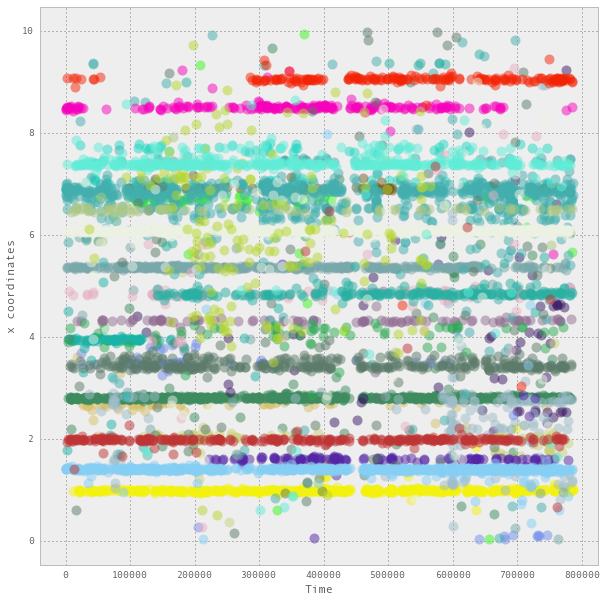

In [480]:
# x coordinates vs visits over time
plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(len(locSmaller.place_id.unique()), color_type='random')

locG1 = locSmaller.groupby('place_id')
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_color_cycle(colors)
ax.margins(0.05)
plt.xlabel('Time')
plt.ylabel('x coordinates')
# ax.set_xlim([4, 6])
# ax.set_ylim([0, 400])

for name, group in locG1:
    ax.plot(group.time, group.x, marker='o', linestyle='', ms=10, label=name, alpha = 0.5, markeredgecolor='none')
# Conclusion: x coordinates don't drift over time.

### y coordinates vs visits over time

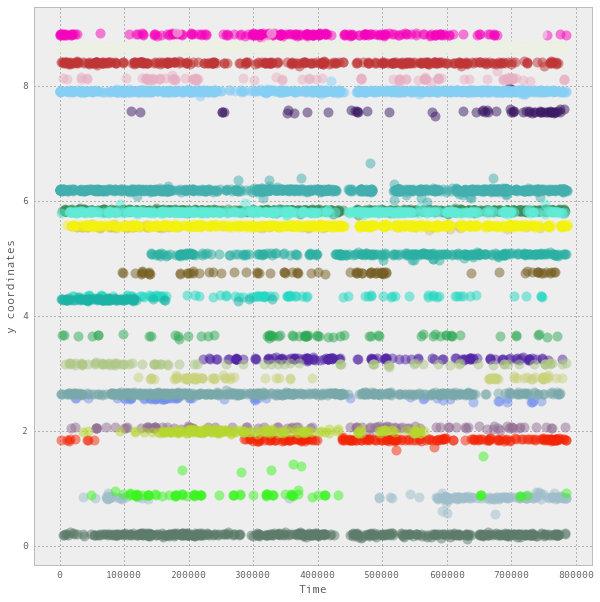

In [482]:
# y coordinates vs visits over time
plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(len(locSmaller.place_id.unique()), color_type='random')

locG1 = locSmaller.groupby('place_id')
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_color_cycle(colors)
ax.margins(0.05)
plt.xlabel('Time')
plt.ylabel('y coordinates')
# ax.set_xlim([4, 6])
# ax.set_ylim([0, 400])

for name, group in locG1:
    ax.plot(group.time, group.y, marker='o', linestyle='', ms=10, label=name, alpha = 0.5, markeredgecolor='none')
# Conclusion: y coordinates don't drift over time, even better than x.

### accuracy vs visits over time

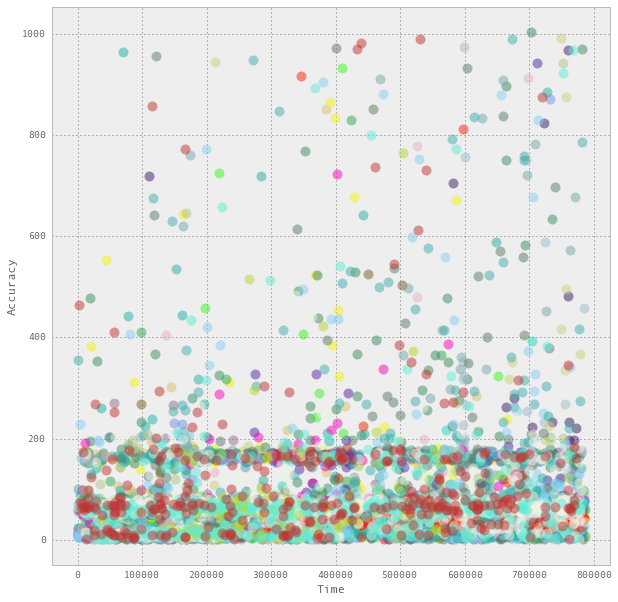

In [483]:
# accuracy vs visits over time
plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(len(locSmaller.place_id.unique()), color_type='random')

locG1 = locSmaller.groupby('place_id')
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_color_cycle(colors)
ax.margins(0.05)
plt.xlabel('Time')
plt.ylabel('Accuracy')
# ax.set_xlim([4, 6])
# ax.set_ylim([0, 400])

for name, group in locG1:
    ax.plot(group.time, group.accuracy, marker='o', linestyle='', ms=10, label=name, alpha = 0.5, markeredgecolor='none')
# Conclusion: y coordinates don't drift over time, even better than x.

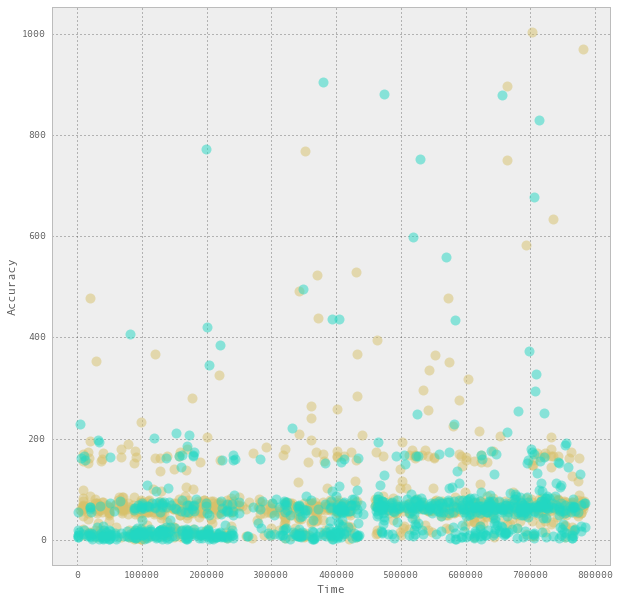

In [488]:
# accuracy vs visits over time for 1st 2 places
locTmp = pd.concat([locG.get_group(locG.groups.keys()[0]),
                  locG.get_group(locG.groups.keys()[1])])
locG1 = locTmp.groupby('place_id')


plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(len(locTmp.place_id.unique()), color_type='random')

fig, ax = plt.subplots(figsize = (10, 10))
ax.set_color_cycle(colors)
ax.margins(0.05)
plt.xlabel('Time')
plt.ylabel('Accuracy')
# ax.set_xlim([4, 6])
# ax.set_ylim([0, 400])

for name, group in locG1:
    ax.plot(group.time, group.accuracy, marker='o', linestyle='', ms=10, label=name, alpha = 0.5, markeredgecolor='none')
# Conclusion: accuracy happens at 3 levels, not surprisingly.

### Weekend visit ratio for 27 places

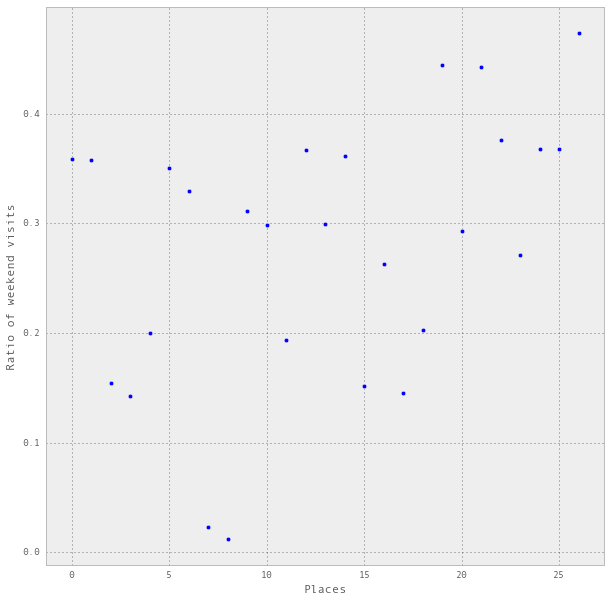

In [366]:
# wkendRatio for 27 places
plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(len(locSmaller.weekday.unique()), color_type='random')

fig, ax = plt.subplots(figsize = (10, 10))
ax.set_color_cycle(colors)
ax.margins(0.05)
plt.xlabel('Places')
plt.ylabel('Ratio of weekend visits')
ax.scatter(pd.Series(range(27)), locG_Time.wkendRatio, marker = 'o', alpha = 1)

# Conclusion: there's a wide range of weekend ratios. Some places are exclusively for weekends. Some are weekdays.


### Peak visit ratio for 27 places

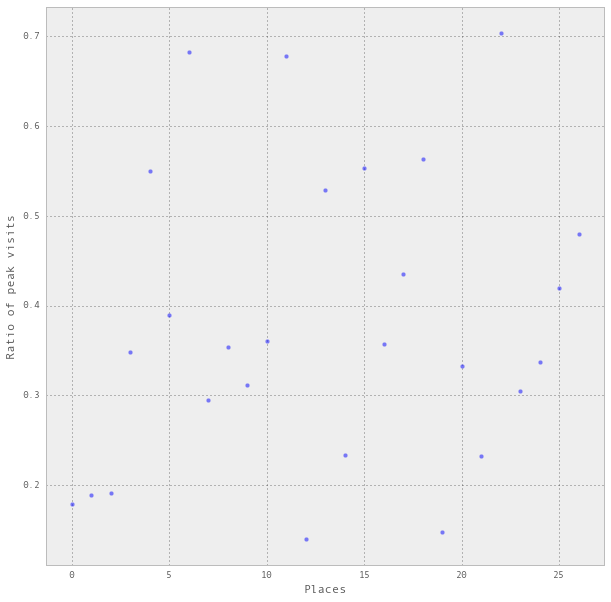

In [363]:
# pkRatio for 27 places
plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(27, color_type='random')

fig, ax = plt.subplots(figsize = (10, 10))
ax.set_color_cycle(colors)
ax.margins(0.05)
plt.xlabel('Places')
plt.ylabel('Ratio of peak visits')
ax.scatter(pd.Series(range(27)), locG_Time.pkRatio, marker = 'o', alpha = 0.5)

# Scale up visualization for all locations

## Create datasets

In [375]:
location_Time = location
location_Time['timeFmtted'] = pd.to_datetime(location_Time.time, unit = 'm')
location_Time['hour'] = location_Time.timeFmtted.apply(lambda x: datetime.datetime.strptime(str(x)[11:], "%H:%M:%S").hour)
location_Time['weekday'] = location_Time.timeFmtted.apply(lambda x: x.dayofweek)
location_Time['month'] = location_Time.timeFmtted.apply(lambda x: x.month)
location_Time['isPeak'] = np.where(((location_Time['hour'] >= 6) & (location_Time['hour'] <= 9)) | ((location_Time['hour'] >= 17) & (location_Time['hour'] <= 21)), 1, 0)
location_Time['isNight'] = np.where((location_Time['hour'] >= 0) & (location_Time['hour'] <= 4), 1, 0)
location_Time['isWeekend'] = np.where((location_Time['weekday']==5) | (location_Time['weekday']==6), 1, 0)
location_Time['isHoliday'] = np.where((location_Time['month'] == 7) | (location_Time['month'] == 8) | (location_Time['month'] == 12) | (location_Time['month'] == 8), 1, 0)

locationG = location_Time.groupby('place_id')
locationG_Time = pd.DataFrame()
locationG_Time['hrHiFreq'] = locationG['hour'].agg(lambda x: x.value_counts().index[0])
locationG_Time['hrLoFreq'] = locationG['hour'].agg(lambda x: x.value_counts().index[-1])
locationG_Time['pkRatio'] = locationG['isPeak'].mean()
locationG_Time['nightRatio'] = locationG['isNight'].mean()

locationG_Time['dayHiFreq'] = locationG['weekday'].agg(lambda x: x.value_counts().index[0])
locationG_Time['dayLoFreq'] = locationG['weekday'].agg(lambda x: x.value_counts().index[-1])
locationG_Time['wkendRatio'] = locationG['isWeekend'].mean()

locationG_Time['mthHiFreq'] = locationG['month'].agg(lambda x: x.value_counts().index[0])
locationG_Time['mthLoFreq'] = locationG['month'].agg(lambda x: x.value_counts().index[-1])
locationG_Time['holRatio'] = locationG['isHoliday'].mean()

In [376]:
location_Time.shape

(108390, 10)

(array([ 24516.,  61527.,  16692.,   3361.,   1017.,    479.,    206.,
           138.,    109.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9]),
 <a list of 9 Patch objects>)

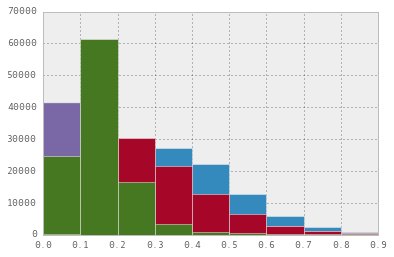

In [495]:
plt.hist(location_Time.pkRatio, bins=np.arange(0,1,0.1))
plt.hist(location_Time.nightRatio, bins=np.arange(0,1,0.1))
plt.hist(location_Time.wkendRatio, bins=np.arange(0,1,0.1))
plt.hist(location_Time.holRatio, bins=np.arange(0,1,0.1))

# Conclusions:
# The average place gets 30 - 40% of their visits during peak hours.
# Most spots are not night spots.
# The average place gets 20 - 30% of their visits during weekends.
# Most spots are not holiday spots.

## Visualize frequencies

(array([ 3110822.,  3167973.,  3571226.,  3492196.,  3724194.,  3077284.,
          980293.,  1750354.,  1712366.,  2732123.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 10 Patch objects>)

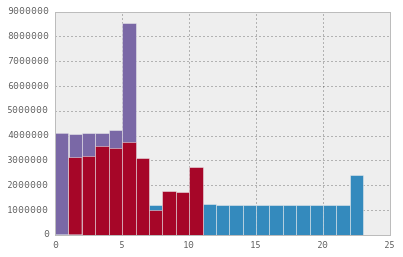

In [500]:
plt.hist(location.hour, bins=np.arange(0,24,1))
plt.hist(location.weekday, bins=np.arange(0,7,1))
plt.hist(location.month, bins=np.arange(1,12,1))

(array([ 18364.,  17074.,  15651.,  15204.,  14500.,  27597.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

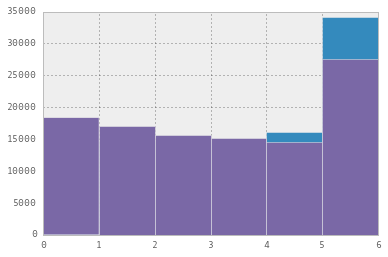

In [503]:
plt.hist(location_Time.dayHiFreq, bins=np.arange(0,7,1))
plt.hist(location_Time.dayLoFreq, bins=np.arange(0,7,1))

## Visualize visiting ratios for all places, during
### 1. Peak hours
### 2. Night hours
### 3. Weekends

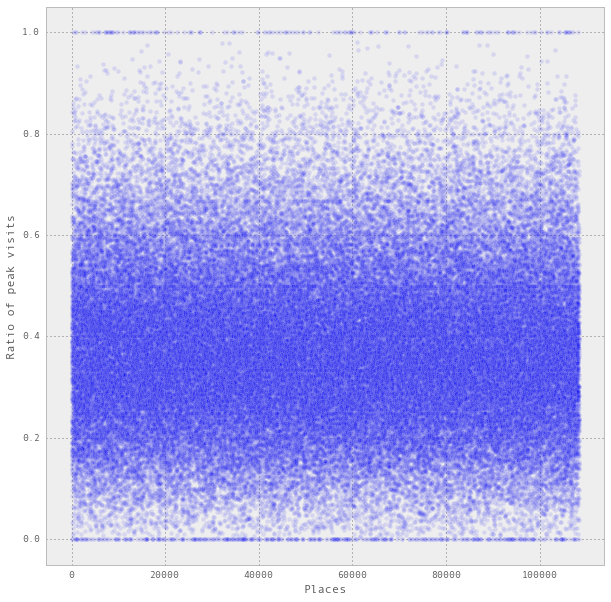

In [384]:
# pkRatio for all places
plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(27, color_type='random')

fig, ax = plt.subplots(figsize = (10, 10))
ax.set_color_cycle(colors)
ax.margins(0.05)
plt.xlabel('Places')
plt.ylabel('Ratio of peak visits')
x = pd.Series(range(len(location.place_id.unique())))
ax.scatter(x, location_Time.pkRatio, marker = 'o', alpha = 0.1)

In [385]:
print sum(location_Time.pkRatio == 0)
print sum(location_Time.pkRatio == 1)

428
160


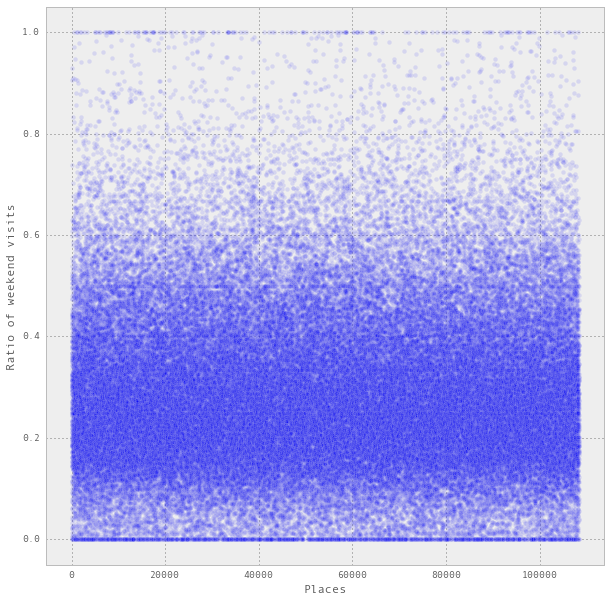

In [380]:
# wkendRatio for all places
plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(len(location.weekday.unique()), color_type='random')

fig, ax = plt.subplots(figsize = (10, 10))
ax.set_color_cycle(colors)
ax.margins(0.05)
plt.xlabel('Places')
plt.ylabel('Ratio of weekend visits')
x = pd.Series(range(len(location.place_id.unique())))
ax.scatter(x, location_Time.wkendRatio, marker = 'o', alpha = 0.1)

In [382]:
print sum(location_Time.wkendRatio == 0)
print sum(location_Time.wkendRatio == 1)
# Conclusion: Purely weekend and weekday places are the minority.
# Some kind of error w time when checking in?

1370
156


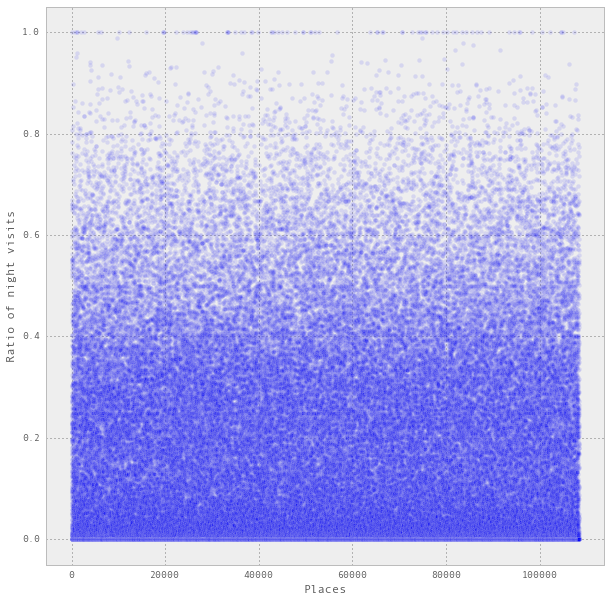

In [507]:
# nightRatio for all places
plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(len(location.weekday.unique()), color_type='random')

fig, ax = plt.subplots(figsize = (10, 10))
ax.set_color_cycle(colors)
ax.margins(0.05)
plt.xlabel('Places')
plt.ylabel('Ratio of night visits')
x = pd.Series(range(len(location.place_id.unique())))
ax.scatter(x, location_Time.nightRatio, marker = 'o', alpha = 0.1)

## Visualize ... ??

In [ ]:
# weekday vs places, factor by weekday

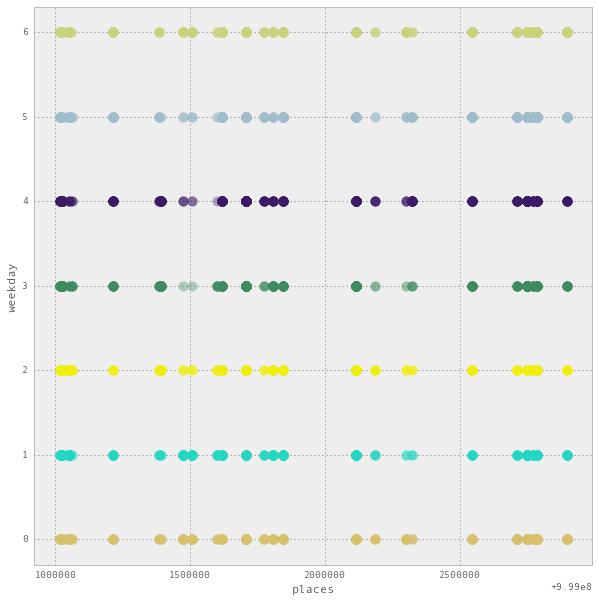

In [508]:
plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(len(locSmaller.weekday.unique()), color_type='random')

locG1 = locSmaller.groupby('weekday')
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_color_cycle(colors)
ax.margins(0.05)
plt.xlabel('places')
plt.ylabel('weekday')
# ax.set_xlim([-5, 11])
# ax.set_ylim([-8, 11])

for name, group in locG1:
    ax.plot(group.place_id, group.weekday, marker='o', linestyle='', ms=10, label=name, alpha = 0.2, markeredgecolor='none')
#    ax.scatter(group.x, group.y, s=50, c = np.array(colors), alpha = 0.1, edgecolor=np.array(colors))

# ax.legend(numpoints=1, loc='upper left')


plt.show()
# Conclusion: x scatter as defined by IQR-Range ratios does not correspond to x scatter as defined by accuracy.

In [ ]:
# y vs x factor by hr visited (24 levels)

In [ ]:
plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(len(locSmaller.hour.unique()), color_type='random')

locG1 = locSmaller.groupby('hour')
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_color_cycle(colors)
ax.margins(0.05)
plt.xlabel('x coordinates')
plt.ylabel('y coordinates')
# ax.set_xlim([-5, 11])
# ax.set_ylim([-8, 11])

for name, group in locG1:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=10, label=name, alpha = 0.3, markeredgecolor='none')
#    ax.scatter(group.x, group.y, s=50, c = np.array(colors), alpha = 0.1, edgecolor=np.array(colors))

ax.legend(numpoints=1, loc='upper left')


plt.show()
# Conclusion: x scatter as defined by IQR-Range ratios does not correspond to x scatter as defined by accuracy.

In [ ]:
# y vs x factor by day visited (7 levels)

In [ ]:
plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(len(locSmaller.weekday.unique()), color_type='random')

locG1 = locSmaller.groupby('weekday')
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_color_cycle(colors)
ax.margins(0.05)
plt.xlabel('x coordinates')
plt.ylabel('y coordinates')
# ax.set_xlim([-5, 11])
# ax.set_ylim([-8, 11])

for name, group in locG1:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=10, label=name, alpha = 0.3, markeredgecolor='none')
#    ax.scatter(group.x, group.y, s=50, c = np.array(colors), alpha = 0.1, edgecolor=np.array(colors))

ax.legend(numpoints=1, loc='upper left')


plt.show()
# Conclusion: x scatter as defined by IQR-Range ratios does not correspond to x scatter as defined by accuracy.

In [ ]:
# y vs x factor by mth visited (12 levels)

In [ ]:
plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(len(locSmaller.month.unique()), color_type='random')

locG1 = locSmaller.groupby('month')
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_color_cycle(colors)
ax.margins(0.05)
plt.xlabel('x coordinates')
plt.ylabel('y coordinates')
# ax.set_xlim([-5, 11])
# ax.set_ylim([-8, 11])

for name, group in locG1:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=10, label=name, alpha = 0.3, markeredgecolor='none')
#    ax.scatter(group.x, group.y, s=50, c = np.array(colors), alpha = 0.1, edgecolor=np.array(colors))

ax.legend(numpoints=1, loc='upper left')


plt.show()
# Conclusion: x scatter as defined by IQR-Range ratios does not correspond to x scatter as defined by accuracy.

In [ ]:
# y vs x factor by weekend/not (2 levels)

In [ ]:
plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(len(locSmaller.isWeekend.unique()), color_type='random')

locG1 = locSmaller.groupby('isWeekend')
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_color_cycle(colors)
ax.margins(0.05)
plt.xlabel('x coordinates')
plt.ylabel('y coordinates')
# ax.set_xlim([-5, 11])
# ax.set_ylim([-8, 11])

for name, group in locG1:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=10, label=name, alpha = 0.7, markeredgecolor='none')
#    ax.scatter(group.x, group.y, s=50, c = np.array(colors), alpha = 0.1, edgecolor=np.array(colors))

ax.legend(numpoints=1, loc='upper left')


plt.show()
# Conclusion: x scatter as defined by IQR-Range ratios does not correspond to x scatter as defined by accuracy.

In [ ]:
# plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
# colors = pd.tools.plotting._get_standard_colors(len(locG_Time.wkendRatio), color_type='random')

# locG1 = locSmaller.groupby('place_id')
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_color_cycle(colors)
ax.margins(0.05)
plt.xlabel('place')
plt.ylabel('weekend ratio')
# ax.set_xlim([-5, 11])
# ax.set_ylim([-8, 11])

# for name, group in locG1:
#     ax.plot(group.x, group.accuracy, marker='o', linestyle='', ms=10, label=name, alpha = 0.7, markeredgecolor='none')
# ax.plot(locG_Time.index, locG_Time.wkendRatio, s=50, c = np.array(colors), alpha = 0.1, edgecolor=np.array(colors))
# ax.scatter(pd.Series(locG_Time.index), locG_Time.wkendRatio, marker = 'o', alpha = 0.5)
ax.scatter(pd.Series(range(27)), locG_Time.wkendRatio, marker = 'o', alpha = 0.5)


# ax.legend(numpoints=1, loc='upper left')


plt.show()
# Conclusion: x scatter as defined by IQR-Range ratios does not correspond to x scatter as defined by accuracy.

In [ ]:
# accuracy vs h

In [ ]:
plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(len(outliers.x_pk_descr.unique()), color_type='random')

locG1 = locSmaller.groupby('place_id')
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_color_cycle(colors)
ax.margins(0.05)
plt.xlabel('hour')
plt.ylabel('Accuracy')
# ax.set_xlim([-5, 11])
# ax.set_ylim([-8, 11])

for name, group in locG1:
    ax.plot(group.x, group.accuracy, marker='o', linestyle='', ms=10, label=name, alpha = 0.7, markeredgecolor='none')
#    ax.scatter(group.x, group.y, s=50, c = np.array(colors), alpha = 0.1, edgecolor=np.array(colors))

ax.legend(numpoints=1, loc='upper left')


plt.show()
# Conclusion: x scatter as defined by IQR-Range ratios does not correspond to x scatter as defined by accuracy.

# Build model using time features (using accuracy to remove x outliers)

## Subset data and create time features

In [41]:
locAcc = location[(location.accuracy > 70) & (location.accuracy < 400)]
# print locAcc.shape # 107851 unique places, reduced from 108390

In [55]:
location_Time = locAcc
location_Time['timeFmtted'] = pd.to_datetime(location_Time.time, unit = 'm')
location_Time['hour'] = location_Time.timeFmtted.apply(lambda x: datetime.datetime.strptime(str(x)[11:], "%H:%M:%S").hour)
location_Time['weekday'] = location_Time.timeFmtted.apply(lambda x: x.dayofweek)
location_Time['month'] = location_Time.timeFmtted.apply(lambda x: x.month)
location_Time['isPeak'] = np.where(((location_Time['hour'] >= 6) & (location_Time['hour'] <= 9)) | ((location_Time['hour'] >= 17) & (location_Time['hour'] <= 21)), 1, 0)
location_Time['isNight'] = np.where((location_Time['hour'] >= 0) & (location_Time['hour'] <= 4), 1, 0)
location_Time['isWeekend'] = np.where((location_Time['weekday']==5) | (location_Time['weekday']==6), 1, 0)
location_Time['isHoliday'] = np.where((location_Time['month'] == 7) | (location_Time['month'] == 8) | (location_Time['month'] == 12) | (location_Time['month'] == 8), 1, 0)

/Users/yingjiang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/yingjiang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/yingjiang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

## Create testing, training and cv sets (10K cv)

In [56]:
test = location_Time.iloc[-(location_Time.shape[0] / 5):] # Get last 1/5 rows as testing data.
train = location_Time.iloc[:(location_Time.shape[0] * 4 / 5 + 1)]
cv = train.iloc[-10000:]
tr = train.iloc[:(train.shape[0]-10000)]

## Further engineer time features in tr set

In [ ]:
# Current columns (14 cols):
# ['row_id', 'x', 'y', 'accuracy', 'time', 'place_id',
#  'timeFmtted', 'hour', 'weekday', 'month',
# 'isPeak', 'isNight', 'isWeekend', 'isHoliday']

# To the training set
# If isPeak > mean(isPeak), call it 1. Otherwise 0.
# If isNight > 
# If isWeekend > mean(isWeekend)
# If isHoliday > 

In [59]:
trG = train.groupby('place_id')
trG_Features = pd.DataFrame()
trG_Features['xMean'] = trG['x'].mean()
trG_Features['yMean'] = trG['y'].mean()
trG_Features['hrHiFreq'] = trG['hour'].agg(lambda x: x.value_counts().index[0])
trG_Features['hrLoFreq'] = trG['hour'].agg(lambda x: x.value_counts().index[-1])
trG_Features['pkRatio'] = trG['isPeak'].mean()
trG_Features['pkRatio1'] = np.where((trG_Features.pkRatio > trG_Features.pkRatio.mean()), 1, 0) # use mean
trG_Features['nightRatio'] = trG['isNight'].mean()
trG_Features['nightRatio1'] = np.where((trG_Features.nightRatio > trG_Features.nightRatio.quantile(0.5)), 1, 0) # use median for it's highly skewed

trG_Features['dayHiFreq'] = trG['weekday'].agg(lambda x: x.value_counts().index[0])
trG_Features['dayLoFreq'] = trG['weekday'].agg(lambda x: x.value_counts().index[-1])
trG_Features['wkendRatio'] = trG['isWeekend'].mean()
trG_Features['wkendRatio1'] = np.where((trG_Features.wkendRatio > trG_Features.wkendRatio.mean()), 1, 0) # use mean

trG_Features['mthHiFreq'] = trG['month'].agg(lambda x: x.value_counts().index[0])
trG_Features['mthLoFreq'] = trG['month'].agg(lambda x: x.value_counts().index[-1])
trG_Features['holRatio'] = trG['isHoliday'].mean()
trG_Features['holRatio1'] = np.where((trG_Features.holRatio > trG_Features.holRatio.quantile(0.5)), 1, 0) # use median for it's highly skewed

## Using the small cv set (10000), train using x, y and '...Ratio1' time features (0 or 1)

In [ ]:
# Compare the 4 'is...' features (pk, night, wkend, hol, in 1s and 0s) with the averaged of the training set (the '...Ratio1' features, 1s and 0s).
# Or just use the 4 ratios as is (the '...Ratio' features, between 0 and 1).

In [85]:
# y_std = trG['y'].std()

cA = np.array(cv[['x', 'y', 'isPeak', 'isNight', 'isWeekend', 'isHoliday']])
cB = np.column_stack((np.array(trG_Features.xMean),
                      np.array(trG_Features.yMean),
                      np.array(trG_Features.pkRatio1),
                      np.array(trG_Features.nightRatio1),
                      np.array(trG_Features.wkendRatio1),
                      np.array(trG_Features.holRatio1)))

train_ids = trG['place_id'].count().index
# train_ids = trG_Features.xMean.index
nsmall = 5


In [88]:
# Using the small cv set (10K), train using x, y, '...Ratio1' features (pk, ngt, wkend, hol)
place_id_min = np.array([])
place_id_possible = np.empty((0, nsmall))

for idx, i in enumerate(cA): # Loop through each cv point, see which tr point it's closest to.
    if idx % 1000 == 0:
        print "Index: ", idx

    d = distance.cdist(i.reshape(1,6), cB, 'euclidean')
    d_min = d[0].min()
    place_id_min = np.append(place_id_min, [train_ids[d[0].argmin()]]) # place_id at minimal distance from cv point
#     print "Min distance: ", d_min
#     print "Point at min distance: ", train_ids[d[0].argmin()]
#     print place_id_min

    # Get the next nsmall (x,y) that's closest to the current point.
    place_id_possible = np.append(place_id_possible, [train_ids[d[0].argsort()[:nsmall]]], axis=0)
#     print "Next ", nsmall, " closest distances: ", d[0][d[0].argsort()[:nsmall]]
#     print "Next ", nsmall, " closest points: ", train_ids[d[0].argsort()[:nsmall]]
#     print place_id_possible

Index:  0
Index:  1000
Index:  2000
Index:  3000
Index:  4000
Index:  5000
Index:  6000
Index:  7000
Index:  8000
Index:  9000


In [89]:
# result4: removed x outliers through acc, using x, y, '...Ratio1' time features; 10K points; 692 correct predictions; potentially 1112
result4 = pd.DataFrame({
         "place_id": cv.place_id,
         "place_id_pred": place_id_min,
         "place_id_possible": place_id_possible.tolist()
         })
sum(result4.place_id == result4.place_id_pred) # 692 only.


692

In [90]:
# How many of the 5 nearest neighbors contain the true value?
contains = np.empty((0, cv.shape[0]))
for ind, val in enumerate(cv.place_id):
    if ind % 1000 == 0:
        print ind
    contains = np.append(contains, val in result4['place_id_possible'][ind:ind+1].values[0])
print sum(contains) # 1112 of them do.
result4['contains'] = contains
# Conclusion: Including time features '...Ratio1' is not effective!

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
1122.0


## Using the small cv set (10000), train using x, y and '...Ratio' time features (between 0 and 1)

In [96]:
cA = np.array(cv[['x', 'y', 'isPeak', 'isNight', 'isWeekend', 'isHoliday']])
cB = np.column_stack((np.array(trG_Features.xMean),
                      np.array(trG_Features.yMean),
                      np.array(trG_Features.pkRatio),
                      np.array(trG_Features.nightRatio),
                      np.array(trG_Features.wkendRatio),
                      np.array(trG_Features.holRatio)))

train_ids = trG['place_id'].count().index
# train_ids = trG_Features.xMean.index
nsmall = 5


In [97]:
# Using the small cv set (10K), train using x, y, '...Ratio' features (pk, ngt, wkend, hol)
place_id_min = np.array([])
place_id_possible = np.empty((0, nsmall))

for idx, i in enumerate(cA): # Loop through each cv point, see which tr point it's closest to.
    if idx % 1000 == 0:
        print "Index: ", idx

    d = distance.cdist(i.reshape(1,6), cB, 'euclidean')
    d_min = d[0].min()
    place_id_min = np.append(place_id_min, [train_ids[d[0].argmin()]]) # place_id at minimal distance from cv point
#     print "Min distance: ", d_min
#     print "Point at min distance: ", train_ids[d[0].argmin()]
#     print place_id_min

    # Get the next nsmall (x,y) that's closest to the current point.
    place_id_possible = np.append(place_id_possible, [train_ids[d[0].argsort()[:nsmall]]], axis=0)
#     print "Next ", nsmall, " closest distances: ", d[0][d[0].argsort()[:nsmall]]
#     print "Next ", nsmall, " closest points: ", train_ids[d[0].argsort()[:nsmall]]
#     print place_id_possible

Index:  0
Index:  1000
Index:  2000
Index:  3000
Index:  4000
Index:  5000
Index:  6000
Index:  7000
Index:  8000
Index:  9000


In [100]:
# result5: removed x outliers through acc, using x, y, '...Ratio' features; 10K points; 104 correct predictions only! potentially 446
result5 = pd.DataFrame({
         "place_id": cv.place_id,
         "place_id_pred": place_id_min,
         "place_id_possible": place_id_possible.tolist()
         })
sum(result5.place_id == result5.place_id_pred) # 692 only.


104

In [101]:
# How many of the 5 nearest neighbors contain the true value?
contains = np.empty((0, cv.shape[0]))
for ind, val in enumerate(cv.place_id):
    if ind % 1000 == 0:
        print ind
    contains = np.append(contains, val in result5['place_id_possible'][ind:ind+1].values[0])
print sum(contains) # 1112 of them do.
result5['contains'] = contains
# Conclusion: Including time features '...Ratio1' is not effective!

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
466.0


# Time Series: Calculate frequencies over time (per week, per month)

## Format time

In [174]:
locSmaller = locSort.iloc[:8082, :] # 27 locations
locSmaller_Time = locSmaller
locSmaller_Time['timeFmtted'] = pd.to_datetime(locSmaller.time, unit = 'm')

/Users/yingjiang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [106]:
print locSmaller_Time.timeFmtted.max()
print locSmaller_Time.timeFmtted.min()

1971-06-30 22:40:00
1970-01-01 00:48:00


In [176]:
locSmaller_Time['Day_Year'] = locSmaller_Time['timeFmtted'].apply(lambda x: "%d/%d" % (x.day, x.year))
locSmaller_Time['Week_Year'] = locSmaller_Time['timeFmtted'].apply(lambda x: "%d/%d" % (x.week, x.year))
locSmaller_Time['Month_Year'] = locSmaller_Time['timeFmtted'].apply(lambda x: "%d/%d" % (x.month, x.year))

/Users/yingjiang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/yingjiang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/yingjiang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [435]:
locSmaller_Time.head()

row_id       x       y  accuracy   time    place_id  \
26269173  26269173  3.6009  5.5570        70  17236  1000015801   
1048797    1048797  2.5880  5.5481       101  81464  1000015801   
9744213    9744213  2.6383  5.5428        51  35456  1000015801   
25157551  25157551  2.3668  5.5547       166  42657  1000015801   
13405440  13405440  2.7124  5.5302       107  63296  1000015801   

                  timeFmtted Day_Year Week_Year Month_Year  
26269173 1970-01-12 23:16:00  12/1970    3/1970     1/1970  
1048797  1970-02-26 13:44:00  26/1970    9/1970     2/1970  
9744213  1970-01-25 14:56:00  25/1970    4/1970     1/1970  
25157551 1970-01-30 14:57:00  30/1970    5/1970     1/1970  
13405440 1970-02-13 22:56:00  13/1970    7/1970     2/1970

## Get frequencies per week

In [229]:
'''#  getting every character before '/'
a1 = np.array([])
find = re.compile(r"^[^/]*")

for i in locSmaller_Time.Week_Year:
    if i[-4:] == '1971':
        a1 = np.append(a1, [int(re.search(find, i).group(0)) + 53])
    if i[-4:] == '1970':
        a1 = np.append(a1, [int(re.search(find, i).group(0))])
'''

# Extracting week using datetime.week:
a2 = np.array([])
for i in locSmaller.timeFmtted:
    if i.year == 1970:
        a2 = np.append(a2, [i.week])
    if i.year == 1971:
        a2 = np.append(a2, [i.week + 53])

print len(set(a2))
print len(a2)

80
8082


In [295]:
weekFreq = pd.DataFrame({
         "place_id": locSmaller.place_id,
         "week": a2
    })

weekFreq = weekFreq.groupby(['place_id', 'week'], as_index = False).size()
weekFreq = pd.DataFrame(weekFreq).reset_index()
weekFreq.columns = ['place_id', 'week', 'frequency']
weekFreq.head()

# Function to extract week and form week-frequency df:
def getWeekFreq(df):
    weeks = np.array([])
    for i in df.timeFmtted:
        if i.year == 1970:
            weeks = np.append(weeks, [i.week])
        if i.year == 1971:
            weeks = np.append(weeks, [i.week + 53])
    weekFreq = pd.DataFrame({
         "place_id": df.place_id,
         "week": weeks
    })
    weekFreq = weekFreq.groupby(['place_id', 'week'], as_index = False).size()
    weekFreq = pd.DataFrame(weekFreq).reset_index()
    weekFreq.columns = ['place_id', 'week', 'frequency']
    return weekFreq

In [445]:
'''
for i in df.place_id.unique():
    print df[df.place_id == i].shape
# The weeks are not consecutive: some weeks have no data, presumeably 0 frequency.
# Need to fill in the weeks. 77 seems to be the max.

# Check for consecutive weeks:
df1 = weekFreq[weekFreq.place_id == weekFreq.place_id.unique()[0]]
for k, g in groupby(enumerate(df1.week), lambda (i, x): i-x):
    print map(itemgetter(1), g)

# Check for the maximum number of weeks
# It appears the data recorded 106 weeks altogether
# Earliest is Week 1; last is Week 106
weekG = weekFreq.groupby('place_id')
for name, group in weekG:
    print group.week.iloc[0]
    print group.week.iloc[-1]

'''

# Function to fill in empty weeks (frequency = 0)
def fillEmptyWeeks(dfGroup):
    b = np.empty((0, 3))
    for i in index:
        if i not in dfGroup.week.values:
            b = np.vstack((b, [int(dfGroup.place_id.unique()), i, 0]))
    dfFull = np.vstack((dfGroup, pd.DataFrame(b)))
    dfFull = pd.DataFrame(dfFull, columns = ['place_id', 'week', 'frequency']).sort_values(['week']).set_index(['week'], drop=False)
    return dfFull

weekG = weekFreq.groupby('place_id')
index = np.arange(start=1, stop=107, step=1)
weekGFull = pd.DataFrame({
                         "place_id": 0,
                         "week": 0,
                         "frequency": 0
                        }, index = [0])


In [447]:
for name, group in weekG:
#     print type(fillEmptyWeeks(group))
    weekGFull = np.vstack((weekGFull, fillEmptyWeeks(group)))

# weekGFull = weekG.apply(fillEmptyWeeks)
weekGFull = pd.DataFrame(weekGFull, columns = ['place_id', 'week', 'frequency']).drop(df.head(1).index)
print weekGFull.shape
weekGFull.head()

(2862, 3)


place_id  week  frequency
1  1.000016e+09   1.0        0.0
2  1.000016e+09   2.0        0.0
3  1.000016e+09   3.0        1.0
4  1.000016e+09   4.0        4.0
5  1.000016e+09   5.0        4.0

## Get frequencies per month

In [448]:
# Extracting month using datetime.week:
a3 = np.array([])
for i in locSmaller.timeFmtted:
    if i.year == 1970:
        a3 = np.append(a3, [i.month])
    if i.year == 1971:
        a3 = np.append(a3, [i.month + 12])

print len(set(a3))
print len(a3)

18
8082


In [449]:
monthFreq = pd.DataFrame({
                         "place_id": locSmaller.place_id,
                         "month": a3
                        })

monthFreq = monthFreq.groupby(['place_id', 'month'], as_index = False).size()
monthFreq = pd.DataFrame(monthFreq).reset_index()
monthFreq.columns = ['place_id', 'month', 'frequency']
monthFreq.head()

place_id  month  frequency
0  1000015801    1.0          9
1  1000015801    2.0         13
2  1000015801    3.0         12
3  1000015801    4.0         13
4  1000015801    5.0          3

In [453]:
monthG = monthFreq.groupby('place_id')
for name, group in monthG:
    print group.shape
#     print group.month.iloc[0]
#     print group.month.iloc[-1]
# Max 18 months. Most have missing months.

(16, 3)
(16, 3)
(18, 3)
(18, 3)
(11, 3)
(12, 3)
(10, 3)
(13, 3)
(13, 3)
(14, 3)
(17, 3)
(14, 3)
(18, 3)
(18, 3)
(6, 3)
(17, 3)
(18, 3)
(18, 3)
(17, 3)
(17, 3)
(16, 3)
(15, 3)
(14, 3)
(18, 3)
(12, 3)
(18, 3)
(18, 3)


In [454]:
# Function to fill in empty months (let missing months' frequency = 0)
def fillEmptyMonths(dfGroup):
    b = np.empty((0, 3))
    for i in index:
        if i not in dfGroup.month.values:
            b = np.vstack((b, [int(dfGroup.place_id.unique()), i, 0]))
    dfFull = np.vstack((dfGroup, pd.DataFrame(b)))
    dfFull = pd.DataFrame(dfFull, columns = ['place_id', 'month', 'frequency']).sort_values(['month']).set_index(['month'], drop=False)
    return dfFull

monthG = monthFreq.groupby('place_id')
index = np.arange(start=1, stop=107, step=1)
monthGFull = pd.DataFrame({
                         "place_id": 0,
                         "month": 0,
                         "frequency": 0
                        }, index = [0])
for name, group in monthG:
#     print type(fillEmptyWeeks(group))
    monthGFull = np.vstack((monthGFull, fillEmptyMonths(group)))

# weekGFull = weekG.apply(fillEmptyWeeks)


In [455]:
monthGFull = pd.DataFrame(monthGFull, columns = ['place_id', 'month', 'frequency']).drop(df.head(1).index)
print monthGFull.shape
monthGFull.head()

(2862, 3)


place_id  month  frequency
1  1.000016e+09    1.0        9.0
2  1.000016e+09    2.0       13.0
3  1.000016e+09    3.0       12.0
4  1.000016e+09    4.0       13.0
5  1.000016e+09    5.0        3.0

## Visualize weekly and monthly frequencies

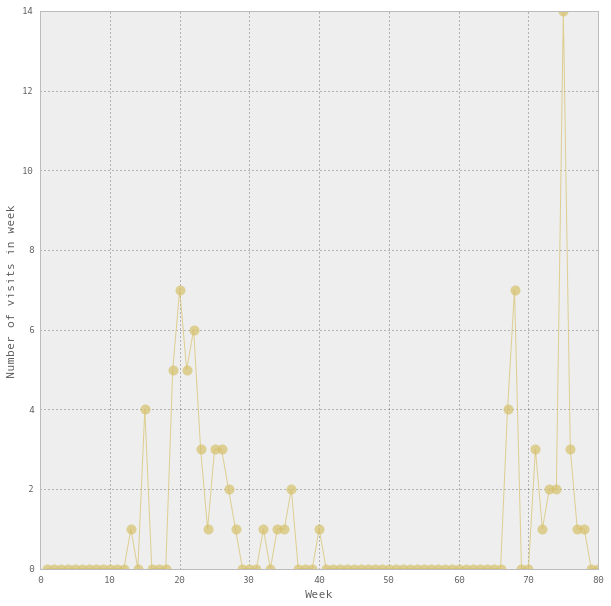

In [464]:
plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(27, color_type='random')

# locG1 = weekGFull.groupby('place_id')
df1 = weekGFull[weekGFull.place_id == weekGFull.place_id.unique()[6]]
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_color_cycle(colors)
ax.margins(0.05)
plt.xlabel('Week')
plt.ylabel('Number of visits in week')
ax.set_xlim([0, 80])
# ax.set_ylim([0, weekGFull.frequency.max()])
ax.set_ylim([0, df1.frequency.max()])

# for name, group in locG1:
#     ax.plot(group.week, group.frequency, marker='o', linestyle='-', ms=10, label=name, alpha = 0.7, markeredgecolor='none')

ax.plot(df1.week, df1.frequency, marker='o', linestyle='-', ms=10, label=name, alpha = 0.7, markeredgecolor='none')

# ax.legend(numpoints=1, loc='upper left')


plt.show()


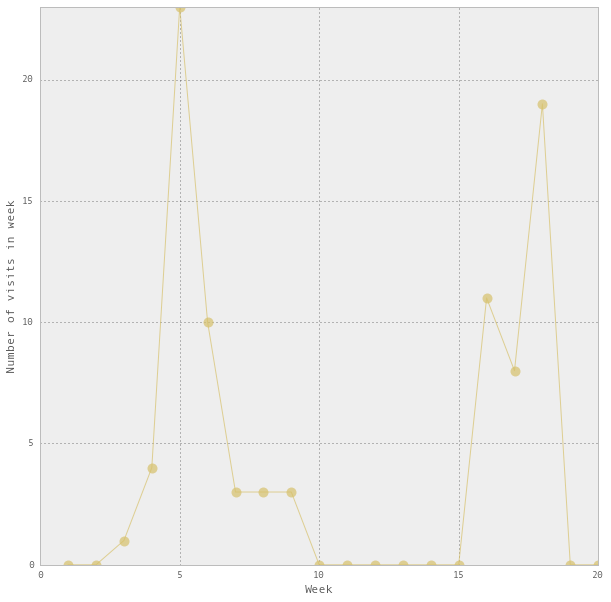

In [468]:
plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(27, color_type='random')

# locG1 = monthGFull.groupby('place_id')
df1 = monthGFull[monthGFull.place_id == monthGFull.place_id.unique()[6]]
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_color_cycle(colors)
ax.margins(0.05)
plt.xlabel('Week')
plt.ylabel('Number of visits in week')
ax.set_xlim([0, 20])
# ax.set_ylim([0, monthGFull.frequency.max()])
ax.set_ylim([0, df1.frequency.max()])

# for name, group in locG1:
#     ax.plot(group.month, group.frequency, marker='o', linestyle='-', ms=10, label=name, alpha = 0.7, markeredgecolor='none')

ax.plot(df1.month, df1.frequency, marker='o', linestyle='-', ms=10, label=name, alpha = 0.7, markeredgecolor='none')

# ax.legend(numpoints=1, loc='upper left')


plt.show()
# Conclusion: Frequency per month is a little sparse. May not be able to differentiate the places.

## Build models using new frequency features, using small cv set (10K)

### Subset data (small cv set, using accuracy to remove outliers)

In [473]:
test = locAcc.iloc[-(locAcc.shape[0] / 5):] # Get last 1/5 rows as testing data.
train = locAcc.iloc[:(locAcc.shape[0] * 4 / 5 + 1)]
cv = train.iloc[-10000:]
tr = train.iloc[:(train.shape[0]-10000)]

print len(train.place_id.unique())
print len(test.place_id.unique())
print len(tr.place_id.unique())
print len(cv.place_id.unique())

107710
105616
107707
9066


### Train with x and y coordinates

In [476]:
trG = tr.groupby('place_id')
y_mean = trG['y'].mean()
y_std = trG['y'].std()
x_mean = trG['x'].mean()

cA = np.array(cv[['x', 'y']])
cB = np.column_stack((np.array(x_mean), np.array(y_mean)))
train_ids = trG['place_id'].count().index
nsmall = 5

In [477]:
place_id_min = np.array([])
place_id_possible = np.empty((0, nsmall))

for idx, i in enumerate(cA): # Loop through each cv point, see which tr point it's closest to.
    if idx % 100 == 0:
        print "Index: ", idx

    d = distance.cdist(i.reshape(1,2), cB, 'euclidean')
    d_min = d[0].min()
    place_id_min = np.append(place_id_min, [train_ids[d[0].argmin()]]) # place_id at minimal distance from cv point
#     print "Min distance: ", d_min
#     print "Point at min distance: ", train_ids[d[0].argmin()]
#     print place_id_min

    # Get the next nsmall (x,y) that's closest to the current point.
    place_id_possible = np.append(place_id_possible, [train_ids[d[0].argsort()[:nsmall]]], axis=0)


Index:  0
Index:  100
Index:  200
Index:  300
Index:  400
Index:  500
Index:  600
Index:  700
Index:  800
Index:  900
Index:  1000
Index:  1100
Index:  1200
Index:  1300
Index:  1400
Index:  1500
Index:  1600
Index:  1700
Index:  1800
Index:  1900
Index:  2000
Index:  2100
Index:  2200
Index:  2300
Index:  2400
Index:  2500
Index:  2600
Index:  2700
Index:  2800
Index:  2900
Index:  3000
Index:  3100
Index:  3200
Index:  3300
Index:  3400
Index:  3500
Index:  3600
Index:  3700
Index:  3800
Index:  3900
Index:  4000
Index:  4100
Index:  4200
Index:  4300
Index:  4400
Index:  4500
Index:  4600
Index:  4700
Index:  4800
Index:  4900
Index:  5000
Index:  5100
Index:  5200
Index:  5300
Index:  5400
Index:  5500
Index:  5600
Index:  5700
Index:  5800
Index:  5900
Index:  6000
Index:  6100
Index:  6200
Index:  6300
Index:  6400
Index:  6500
Index:  6600
Index:  6700
Index:  6800
Index:  6900
Index:  7000
Index:  7100
Index:  7200
Index:  7300
Index:  7400
Index:  7500
Index:  7600
Index:  770

In [478]:
# result2: using x and y; 10K points; 1334 correct predictions; potentially 3568
result2 = pd.DataFrame({
         "place_id": cv.place_id,
         "place_id_pred": place_id_min,
         "place_id_possible": place_id_possible.tolist()
         })
sum(result2.place_id == result2.place_id_pred) 

1334

In [479]:
# Do the 5 nearest neighbors contain the true value?
contains = np.empty((0, result2.shape[0]))
for ind, val in enumerate(result2.place_id):
    if ind % 1000 == 0:
        print ind
    contains = np.append(contains, val in result2['place_id_possible'][ind:ind+1].values[0])
sum(contains) # 3568 of them do.
# If these can be extracted, the correct predictions become 3568. Nearly 3x improvement.


0
1000
2000
3000
4000
5000
6000
7000
8000
9000


3568.0

In [480]:

result2['contains'] = contains
pickle.dump(result2, open('cv_pred2.p', 'wb')) # Got accidentally erased :(

### Extract frequency features for the 5 nearest neighbors. Compare each cv row's week to the 5 nearest neighbors

In [644]:
# Function to extract week and get week-frequency df:
def getWeekFreq(df):
    # df is a dataframe containing at least place_id and timeFmtted columns
    # In this case, df = 5 nearest neighbors
    # Returns a df grouped by place_id, columns of weeks (periods) and corresponding frequencies
    weeks = np.array([])
    for ind, i in enumerate(df.timeFmtted):
#         if ind % 10000 == 0:
#             print ind
        if i.year == 1970:
            weeks = np.append(weeks, [i.week])
        if i.year == 1971:
            weeks = np.append(weeks, [i.week + 53])
    weekFreq = pd.DataFrame({
         "place_id": df.place_id,
         "week": weeks
    })
    weekFreq = weekFreq.groupby(['place_id', 'week'], as_index = False).size()
    weekFreq = pd.DataFrame(weekFreq).reset_index()
    weekFreq.columns = ['place_id', 'week', 'frequency']
    weekFreq = weekFreq.groupby('place_id')
    return weekFreq

# Function to fill in empty weeks (frequency = 0)
def fillEmptyWeeks(df):
    # df is a groupby object by place_id, with week numbers (periods) and corresponding frequencies
    index = np.arange(start=1, stop=107, step=1) # Weeks 1 to 106
    b = np.empty((0, 3)) # Initiate np array of 0 rows, 3 columns. Will append rows.
    for i in index:
        if i not in df.week.values:
            b = np.vstack((b, [int(df.place_id.unique()), i, 0]))
    dfFull = np.vstack((df, pd.DataFrame(b)))
    dfFull = pd.DataFrame(dfFull, columns = ['place_id', 'week', 'frequency']).sort_values(['week']).set_index(['week'], drop=False)
    return dfFull



In [500]:
# Convert time to timeFmtted
tr['timeFmtted'] = pd.to_datetime(tr.time, unit = 'm')
cv['timeFmtted'] = pd.to_datetime(cv.time, unit = 'm')

(2862, 3)


place_id  week  frequency
1  1.000016e+09   1.0        0.0
2  1.000016e+09   2.0        0.0
3  1.000016e+09   3.0        1.0
4  1.000016e+09   4.0        4.0
5  1.000016e+09   5.0        4.0

In [687]:
place_id_possible2 = np.empty((0, nsmall))

for ind, val in enumerate(result2.place_id_possible.values):
    if ind % 1000 == 0:
        print 'cv row: ', ind
    
    # For each cv row, get the 5 nearest neighbors.
    trTime = tr.loc[tr['place_id'].isin(val)]

    # For each of the 5 nearest neighbor, extract weekly frequencies
    weekFreq = getWeekFreq(trTime)
    # For each of the 5 nearest neighbor, fill empty weeks
    weekGFull = pd.DataFrame({
                             "place_id": 0,
                             "week": 0,
                             "frequency": 0
                            }, index = [0])
    for name, group in weekFreq:
        weekGFull = np.vstack((weekGFull, fillEmptyWeeks(group)))
    weekGFull = pd.DataFrame(weekGFull, columns = ['place_id', 'week', 'frequency']).drop(df.head(1).index) # Get rid of 1st row
    # 5 places with 106 weeks each, 530 rows.
    
    # Compare unknown visit's week number with the weekly visit frequencies of the 5 nearest neighbors
    nsmallFreq = weekGFull[weekGFull.week == cv.timeFmtted.iloc[ind].week]
    
    # Get the place_id(s) that have the highest weekly frequency
    if max(nsmallFreq.frequency) != 0:
        tmp = nsmallFreq.place_id[nsmallFreq.frequency == max(nsmallFreq.frequency)]
        tmp = list(tmp) + [0] * (nsmall - len(tmp))
        place_id_possible2 = np.append(place_id_possible2, [tmp])
    else:
        tmp = [0] * nsmall
        place_id_possible2 = np.append(place_id_possible2, [tmp])
#     print 'The likely place(s) based on weekly visits is(are): ', place_id_possible2
        
    

cv row:  0
cv row:  1000
cv row:  2000
cv row:  3000
cv row:  4000
cv row:  5000
cv row:  6000
cv row:  7000
cv row:  8000
cv row:  9000


In [690]:
place_id_possible2 = np.reshape(place_id_possible2, (10000, 5))
result2['place_id_refined'] = place_id_possible2.tolist()

In [695]:
# Do the weekly visit frequencies correspond to the xy predictions?
containsXY = np.empty((0, result2.shape[0]))
for ind, val in enumerate(result2.place_id_pred):
    if ind % 1000 == 0:
        print ind
    containsXY = np.append(containsXY, val in result2['place_id_refined'][ind:ind+1].values[0])
sum(containsXY) # 2349 of them contain the xy prediction

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


2349.0

In [694]:
# Do the weekly visit frequencies contain the true value?
containsFreq = np.empty((0, result2.shape[0]))
for ind, val in enumerate(result2.place_id):
    if ind % 1000 == 0:
        print ind
    containsFreq = np.append(containsFreq, val in result2['place_id_refined'][ind:ind+1].values[0])
sum(containsFreq) # 1788 of them contain the true place

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


1788.0

In [701]:
# Do the weekly visit frequencies (singly predicted) give the true value with a higher accuracy?

lengthFreqPred = np.empty((0, result2.shape[0]))
for i in result2.place_id_refined:
    lengthFreqPred = np.append(lengthFreqPred, len(filter(lambda a: a != 0, i)))
sum(lengthFreqPred ==1) # 7128



[[0.0, 0.0, 0.0, 0.0, 0.0],
 [8339817597.0, 0.0, 0.0, 0.0, 0.0],
 [1079554288.0, 0.0, 0.0, 0.0, 0.0],
 [7710686483.0, 0.0, 0.0, 0.0, 0.0],
 [2381703511.0, 0.0, 0.0, 0.0, 0.0],
 [9133671012.0, 0.0, 0.0, 0.0, 0.0],
 [3826935457.0, 0.0, 0.0, 0.0, 0.0],
 [8949018987.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0],
 [1946819250.0, 0.0, 0.0, 0.0, 0.0],
 [5665363530.0, 6649936087.0, 9733953357.0, 0.0, 0.0],
 [7776135057.0, 0.0, 0.0, 0.0, 0.0],
 [6635710657.0, 0.0, 0.0, 0.0, 0.0],
 [1242669260.0, 0.0, 0.0, 0.0, 0.0],
 [5778132796.0, 0.0, 0.0, 0.0, 0.0],
 [1219798332.0, 4470515053.0, 0.0, 0.0, 0.0],
 [5776603930.0, 0.0, 0.0, 0.0, 0.0],
 [9128321274.0, 0.0, 0.0, 0.0, 0.0],
 [1283131832.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0]]

In [747]:
# result2['place_id_pred_freq'] = result2['place_id_refined'][lengthFreqPred == 1]
# result2 = result2.fillna(0)

place_id_pred_freq = np.empty((0, result2.shape[0]))
for i in result2.place_id_refined:
#     place_id_pred_freq = np.append(place_id_pred_freq, filter(lambda a: a != 0, i))
    place_id_pred_freq = np.append(place_id_pred_freq, i[0])

result2['place_id_pred_freq'] = place_id_pred_freq.tolist()
# result2.drop('place_id_pred_freq', axis=1, inplace=True)

In [749]:
sum(result2.place_id == result2.place_id_pred_freq)

1563

In [756]:
pred1 = result2.place_id[result2.place_id == result2.place_id_pred]
pred2 = result2.place_id[result2.place_id == result2.place_id_pred_freq]

In [761]:

for i in pred1:
    if i in pred2:
        print 'Yes'

In [759]:
print len(pred1)
print len(pred2)

1334
1563


# Building models using RF

In [4]:
## Subset data by accuracy
locAcc = location[(location.accuracy > 70) & (location.accuracy < 400)]

In [5]:
## Create time features
locTime = locAcc
locTime['timeFmtted'] = pd.to_datetime(locTime.time, unit = 'm')
locTime['hour'] = locTime.timeFmtted.apply(lambda x: datetime.datetime.strptime(str(x)[11:], "%H:%M:%S").hour)
locTime['weekday'] = locTime.timeFmtted.apply(lambda x: x.dayofweek)
locTime['month'] = locTime.timeFmtted.apply(lambda x: x.month)
locTime['isPeak'] = np.where(((locTime['hour'] >= 6) & (locTime['hour'] <= 9)) | ((locTime['hour'] >= 17) & (locTime['hour'] <= 21)), 1, 0)
locTime['isNight'] = np.where((locTime['hour'] >= 0) & (locTime['hour'] <= 4), 1, 0)
locTime['isWeekend'] = np.where((locTime['weekday']==5) | (locTime['weekday']==6), 1, 0)
locTime['isHoliday'] = np.where((locTime['month'] == 7) | (locTime['month'] == 8) | (locTime['month'] == 12) | (locTime['month'] == 8), 1, 0)


/Users/yingjiang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/yingjiang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/yingjiang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [6]:
## Make cv set (size = 10K)
test = locTime.iloc[-(locTime.shape[0] / 5):] # Get last 1/5 rows as testing data.
train = locTime.iloc[:(locTime.shape[0] * 4 / 5 + 1)]
cv = train.iloc[-10000:]
tr = train.iloc[:(train.shape[0]-10000)]

In [7]:
X = tr.drop(['row_id', 'place_id', 'accuracy', 'time', 'timeFmtted'], axis = 1)
Y = tr.place_id

In [ ]:
clf = RandomForestClassifier(n_estimators=10, criterion = 'entropy')
clf = clf.fit(X, Y)

In [1]:
for i in X:
    print type(i)

NameError: name 'X' is not defined

In [13]:
X.columns

Index([u'x', u'y', u'timeFmtted', u'hour', u'weekday', u'month', u'isPeak',
       u'isNight', u'isWeekend', u'isHoliday'],
      dtype='object')